# 1. Install & Import Dependencies

In [1]:
import os
import json
import random
from pathlib import Path
from typing import List, Tuple, Dict
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import pickle
import pandas as pd

# Optional: optuna for HPO (install if needed)
try:
    import optuna
    OPTUNA_AVAILABLE = True
except Exception:
    OPTUNA_AVAILABLE = False

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

print(f"Using device: {DEVICE}")

import shutil
from IPython.display import FileLink


Using device: cuda


# 2. Create Organized Output Structure

In [2]:
def create_output_structure():
    """Create organized output folder structure for BERT+SSL Rhythm Classification"""
    base_dirs = {
        'outputs': 'BERT_SSL_RHYTHM',
        'default_bert': 'BERT_SSL_RHYTHM/Default_BERT_SSL',
        'default_models': 'BERT_SSL_RHYTHM/Default_BERT_SSL/Model_Save',
        'default_history': 'BERT_SSL_RHYTHM/Default_BERT_SSL/Training_History',
        'default_matrix': 'BERT_SSL_RHYTHM/Default_BERT_SSL/Matrix',
        'hpo_bert': 'BERT_SSL_RHYTHM/HPO_BERT_SSL',
        'hpo_models': 'BERT_SSL_RHYTHM/HPO_BERT_SSL/Model_Save',
        'hpo_history': 'BERT_SSL_RHYTHM/HPO_BERT_SSL/Training_History',
        'hpo_matrix': 'BERT_SSL_RHYTHM/HPO_BERT_SSL/Matrix',
    }
    
    for dir_path in base_dirs.values():
        os.makedirs(dir_path, exist_ok=True)
    
    return base_dirs

def create_class_mapping_json(classes, save_path='BERT_SSL_RHYTHM/class_mapping.json'):
    """Create class mapping JSON file for rhythm classification"""
    class_mapping = {
        'classes': classes,
        'class_to_idx': {cls: idx for idx, cls in enumerate(classes)},
        'idx_to_class': {idx: cls for idx, cls in enumerate(classes)},
        'description': {
            'N': 'Normal Rhythm',
            'AFIB': 'Atrial Fibrillation',
            'VFL': 'Ventricular Flutter'
        }
    }
    
    with open(save_path, 'w') as f:
        json.dump(class_mapping, f, indent=2)
    
    print(f"Class mapping saved to {save_path}")
    return class_mapping

def create_readme_file(save_path='BERT_SSL_RHYTHM/README.md'):
    """Create comprehensive README file for BERT+SSL Rhythm Classification"""
    readme_content = """# ECG Rhythm Classification with BERT + Self-Supervised Learning (BERT+SSL)

This project implements ECG rhythm classification using a BERT-based architecture with Self-Supervised Learning approach for comprehensive evaluation and comparison between default configuration and hyperparameter-optimized models.

## Project Structure

```
BERT_SSL_RHYTHM/
├── README.md                           # This file
├── class_mapping.json                  # Class labels and descriptions
├── config_default.json                 # Default configuration parameters
├── config_hpo.json                     # Best hyperparameters from tuning
├── detailed_metrics_comparison.xlsx    # Comprehensive metrics comparison
│
├── Default_BERT_SSL/                   # Default BERT+SSL model results
│   ├── Model_Save/                     # Trained model files
│   │   ├── fold1.pth                   # Model weights for fold 1
│   │   ├── fold2.pth                   # Model weights for fold 2
│   │   ├── fold3.pth                   # Model weights for fold 3
│   │   ├── fold4.pth                   # Model weights for fold 4
│   │   └── fold5.pth                   # Model weights for fold 5
│   │
│   ├── Training_History/               # Training progress visualization
│   │   ├── training_history_per_fold.png  # Loss/accuracy plots for all folds
│   │   ├── fold1_history.png           # Individual fold training history
│   │   ├── fold2_history.png
│   │   ├── fold3_history.png
│   │   ├── fold4_history.png
│   │   └── fold5_history.png
│   │
│   └── Matrix/                         # Confusion matrices and evaluation
│       ├── aggregated_confusion_matrix.png     # Combined results
│       ├── train_confusion_matrix.png          # Training set evaluation
│       ├── test_confusion_matrix.png           # Test set evaluation
│       ├── fold1_train_confusion_matrix.png    # Per-fold training matrices
│       ├── fold1_val_confusion_matrix.png      # Per-fold validation matrices
│       ├── fold1_test_confusion_matrix.png     # Per-fold test matrices
│       └── ... (similar for folds 2-5)
│
└── HPO_BERT_SSL/                       # Hyperparameter-optimized BERT+SSL results
    ├── Model_Save/                     # Same structure as Default_BERT_SSL
    ├── Training_History/
    └── Matrix/
```

## Dataset Classes

The model classifies ECG rhythms into 3 categories:
- **N**: Normal Rhythm
- **AFIB**: Atrial Fibrillation
- **VFL**: Ventricular Flutter

## Model Architecture: BERT + Self-Supervised Learning

### Architecture Overview:
- **Base Model**: BERT-like Transformer with SSL
- **Input**: 1D ECG rhythm signals (variable length, padded to max length in batch)
- **Patch Size**: Configurable (default: 16)
- **Hidden Dimension**: Configurable (default: 128)
- **Attention Heads**: Configurable (default: 4)
- **Transformer Layers**: Configurable (default: 6)
- **MLM Masking Ratio**: Configurable (default: 0.15)

### Self-Supervised Learning Components:
1. **Contrastive Loss**: Maximizes agreement between augmented views of the same sample
2. **Masked Language Modeling (MLM)**: BERT-style masked token prediction
3. **Combined Training**: Multi-task learning with weighted loss combination

### Training Strategy:
- **Two-Phase Training**:
  - Phase 1: Self-supervised pretraining with contrastive + MLM loss
  - Phase 2: Fine-tuning with classification loss
- **Data Augmentation**: Time-shifting, amplitude scaling, noise injection for contrastive learning

## Training Strategy

### 5-Fold Cross Validation
- Stratified splitting to maintain class balance
- Each fold trained for specified epochs
- Best fold selected based on validation accuracy

### Two Training Approaches:
1. **Default Configuration**: Pre-defined hyperparameters
2. **Hyperparameter Optimization**: Optuna-based tuning with 3-fold inner CV

## Evaluation Metrics

### Per-Class Metrics:
- **Accuracy**: (TP + TN) / (TP + TN + FP + FN) per class
- **Sensitivity (Recall)**: TP / (TP + FN) per class
- **Specificity**: TN / (TN + FP) per class  
- **F1-Score**: 2 * (Precision * Recall) / (Precision + Recall) per class

### Aggregated Metrics:
- **Overall Accuracy**: Mean of per-class accuracies
- **Macro Average**: Unweighted mean of per-class metrics
- **Weighted Average**: Sample-weighted mean of per-class metrics

## Performance Summary

The project compares Default BERT+SSL vs Hyperparameter-Optimized BERT+SSL across:
- **Training Performance**: 5-fold cross-validation results
- **Generalization**: Test set evaluation on best fold
- **Robustness**: Per-class performance analysis
- **Efficiency**: Training convergence and stability
- **SSL Benefits**: Improved feature learning through self-supervision

Best models are selected based on validation accuracy and evaluated on held-out test set for final performance assessment.

## Dependencies
- PyTorch
- scikit-learn  
- NumPy
- Pandas
- Matplotlib
- Seaborn
- Optuna (optional, for hyperparameter optimization)
"""
    
    with open(save_path, 'w') as f:
        f.write(readme_content)
    
    print(f"README.md created at {save_path}")

# Create output structure
OUTPUT_DIRS = create_output_structure()
print("Created organized output directory structure")

Created organized output directory structure


# 3. Load Datasets

=== Dataset Distribution (Train) ===
AFIB      : 1600
N         : 1600
VFL       : 1600

=== Dataset Distribution (Test) ===
AFIB      : 400
N         : 400
VFL       : 400


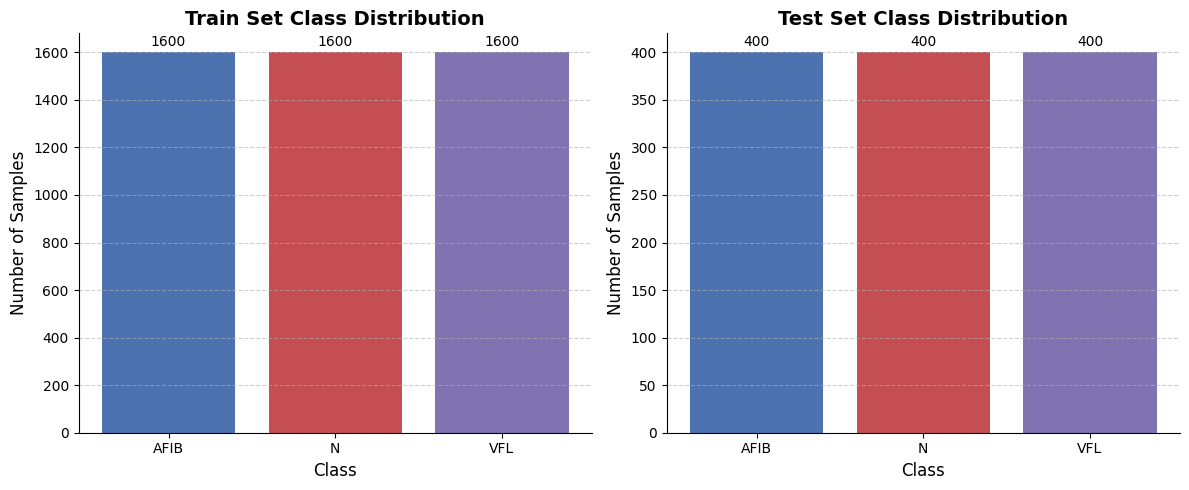

In [3]:
base_dir = '/kaggle/input/split-rythm/SPLIT_SLIDING_FINAL'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

def count_files_per_class(directory):
    """Count the number of files per class in a given directory."""
    counts = {}
    for class_name in sorted(os.listdir(directory)):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            counts[class_name] = len(os.listdir(class_path))
    return counts

# Count data per class
train_counts = count_files_per_class(train_dir)
test_counts = count_files_per_class(test_dir)

# Display in console
print("=== Dataset Distribution (Train) ===")
for k, v in train_counts.items():
    print(f"{k:<10}: {v}")

print("\n=== Dataset Distribution (Test) ===")
for k, v in test_counts.items():
    print(f"{k:<10}: {v}")

# --- Visualization ---
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
bar_colors = ['#4C72B0', '#C44E52', '#8172B2']

# Plot Train
axes[0].bar(train_counts.keys(), train_counts.values(), color=bar_colors)
axes[0].set_title('Train Set Class Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Class', fontsize=12)
axes[0].set_ylabel('Number of Samples', fontsize=12)

# Add numbers on bars (Train)
for i, value in enumerate(train_counts.values()):
    axes[0].text(i, value + max(train_counts.values())*0.01, str(value), ha='center', va='bottom', fontsize=10)

# Plot Test
axes[1].bar(test_counts.keys(), test_counts.values(), color=bar_colors)
axes[1].set_title('Test Set Class Distribution', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Class', fontsize=12)
axes[1].set_ylabel('Number of Samples', fontsize=12)

# Add numbers on bars (Test)
for i, value in enumerate(test_counts.values()):
    axes[1].text(i, value + max(test_counts.values())*0.01, str(value), ha='center', va='bottom', fontsize=10)

# General styling
for ax in axes:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

In [4]:
class ECGRhythmDataset(Dataset):
    """Load .npy rhythm files and labels. Assumes folder structure where parent folder name is class label."""
    def __init__(self, root_dirs: List[Path], classes: List[str], transform=None):
        self.files = []
        self.labels = []
        self.classes = classes
        self.class_to_idx = {c: i for i, c in enumerate(classes)}
        
        for root in root_dirs:
            root = Path(root)
            if not root.exists():
                continue
            for p in root.glob('**/*.npy'):
                try:
                    cls = p.parent.name
                    if cls not in self.class_to_idx:
                        continue
                    self.files.append(str(p))
                    self.labels.append(self.class_to_idx[cls])
                except Exception:
                    continue
        
        assert len(self.files) == len(self.labels), "files/labels mismatch"
        self.transform = transform
    
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, idx):
        arr = np.load(self.files[idx])
        arr = np.asarray(arr, dtype=np.float32).squeeze()
        
        if arr.std() > 0:
            arr = (arr - arr.mean()) / (arr.std() + 1e-8)
        
        label = int(self.labels[idx])
        x = torch.from_numpy(arr).float()
        
        return x, label

# 4. Config

In [5]:
DEFAULT_CONFIG = {
    "seed": 42,
    "dataset": {
        "train_dirs": ["/kaggle/input/split-rythm/SPLIT_SLIDING_FINAL/train"],
        "test_dirs": ["/kaggle/input/split-rythm/SPLIT_SLIDING_FINAL/test"],
        "classes": ["AFIB", "N", "VFL"],  # 3 classes for rhythm classification
    },
    "training": {
        "device": "cuda" if torch.cuda.is_available() else "cpu",
        "batch_size": 64,
        "num_epochs": 20,
        "learning_rate": 1e-3,
        "weight_decay": 1e-4,
        "num_workers": 2,
        "ssl_weight": 0.5,
        "pretrain_epochs": 20,
    },
    "model": {
        "patch_size": 16,
        "hidden_dim": 128,
        "n_heads": 4,
        "n_layers": 6,
        "mlm_mask_ratio": 0.15,
        "dropout": 0.1,
        "projection_dim": 64,
        "temperature": 0.07,
    },
}

os.makedirs('BERT_SSL_RHYTHM', exist_ok=True)
with open('BERT_SSL_RHYTHM/config_default.json', 'w') as f:
    json.dump(DEFAULT_CONFIG, f, indent=2)

# Create class mapping and README
create_class_mapping_json(DEFAULT_CONFIG['dataset']['classes'])
create_readme_file()

# Utilities
def set_seed(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(DEFAULT_CONFIG['seed'])

def collate_ecg(batch):
    """Pad to max length in batch to enable batching if rhythms vary in length."""
    xs, ys = zip(*batch)
    lengths = [x.shape[0] for x in xs]
    maxlen = max(lengths)
    batch_x = torch.zeros(len(xs), maxlen)
    for i, x in enumerate(xs):
        batch_x[i, :x.shape[0]] = x
    return batch_x.unsqueeze(1), torch.tensor(ys, dtype=torch.long)


Class mapping saved to BERT_SSL_RHYTHM/class_mapping.json
README.md created at BERT_SSL_RHYTHM/README.md


# 5. Load Pre-Train Model Transformer BERT+SSL

In [6]:
class PatchEmbed1D(nn.Module):
    def __init__(self, in_chans=1, patch_size=16, embed_dim=128):
        super().__init__()
        self.patch_size = patch_size
        self.proj = nn.Conv1d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)
    
    def forward(self, x):
        x = self.proj(x)
        x = x.permute(0, 2, 1)
        return x

class ProjectionHead(nn.Module):
    """Projection head for contrastive learning"""
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )
    
    def forward(self, x):
        return self.net(x)

class ECGAugmentation:
    """Simple augmentation strategies for ECG signals"""
    @staticmethod
    def time_shift(x, shift_max=0.1):
        B, N, D = x.shape
        shift = int(shift_max * N)
        if shift > 0:
            shift = torch.randint(-shift, shift + 1, (1,)).item()
            if shift > 0:
                x = torch.cat([x[:, shift:], x[:, :shift]], dim=1)
            elif shift < 0:
                x = torch.cat([x[:, shift:], x[:, :shift]], dim=1)
        return x
    
    @staticmethod
    def amplitude_scale(x, scale_range=(0.8, 1.2)):
        scale = torch.FloatTensor(1).uniform_(*scale_range).to(x.device)
        return x * scale
    
    @staticmethod
    def add_noise(x, noise_std=0.01):
        noise = torch.randn_like(x) * noise_std
        return x + noise
    
    @staticmethod
    def augment(x):
        x = ECGAugmentation.time_shift(x)
        x = ECGAugmentation.amplitude_scale(x)
        x = ECGAugmentation.add_noise(x)
        return x

class BERT_SSL(nn.Module):
    """BERT-like architecture with Self-Supervised Learning for ECG rhythm classification"""
    def __init__(self, num_patches, patch_size, cfg, num_classes=3):
        super().__init__()
        hidden_dim = cfg['hidden_dim']
        self.patch_embed = PatchEmbed1D(in_chans=1, patch_size=patch_size, embed_dim=hidden_dim)
        self.pos_embed = nn.Parameter(torch.randn(1, num_patches, hidden_dim))
        self.mask_token = nn.Parameter(torch.randn(1, 1, hidden_dim))
        
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_dim,
            nhead=cfg['n_heads'],
            dim_feedforward=hidden_dim * 4,
            dropout=cfg.get('dropout', 0.1),
            activation='gelu',
            batch_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=cfg.get('n_layers', 6))
        
        self.mlm_head = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.GELU(),
            nn.LayerNorm(hidden_dim),
            nn.Linear(hidden_dim, patch_size)
        )
        
        self.projection_head = ProjectionHead(
            input_dim=hidden_dim,
            hidden_dim=hidden_dim,
            output_dim=cfg.get('projection_dim', 64)
        )
        
        # Classification head - updated for 3 classes
        self.classifier = nn.Sequential(
            nn.LayerNorm(hidden_dim),
            nn.Dropout(cfg.get('dropout', 0.1)),
            nn.Linear(hidden_dim, num_classes)
        )
        
        self.mlm_mask_ratio = cfg.get('mlm_mask_ratio', 0.15)
        self.temperature = cfg.get('temperature', 0.07)
    
    def mlm_masking(self, x):
        """BERT-style masked language modeling masking"""
        B, N, D = x.shape
        k = int(self.mlm_mask_ratio * N)
        
        noise = torch.rand(B, N, device=x.device)
        ids_shuffle = torch.argsort(noise, dim=1)
        ids_mask = ids_shuffle[:, :k]
        
        mask = torch.zeros(B, N, device=x.device, dtype=torch.bool)
        mask.scatter_(1, ids_mask, True)
        
        x_masked = x.clone()
        x_masked[mask] = self.mask_token.expand(B, k, -1).reshape(-1, D)
        
        return x_masked, mask
    
    def forward(self, x, mode='pretrain'):
        patches = self.patch_embed(x)
        B, N, D = patches.shape
        patches = patches + self.pos_embed[:, :N, :]
        
        if mode == 'pretrain':
            x_masked, mask = self.mlm_masking(patches)
            x_enc = self.encoder(x_masked)
            pooled = x_enc.mean(dim=1)
            z = self.projection_head(pooled)
            mlm_pred = self.mlm_head(x_enc[mask])
            return z, mlm_pred, mask
        else:
            x_enc = self.encoder(patches)
            pooled = x_enc.mean(dim=1)
            logits = self.classifier(pooled)
            return logits, None

class NTXentLoss(nn.Module):
    """Normalized Temperature-scaled Cross Entropy Loss"""
    def __init__(self, temperature=0.07):
        super().__init__()
        self.temperature = temperature
        self.criterion = nn.CrossEntropyLoss()
    
    def forward(self, z_i, z_j):
        B = z_i.shape[0]
        
        z_i = nn.functional.normalize(z_i, dim=1)
        z_j = nn.functional.normalize(z_j, dim=1)
        
        z = torch.cat([z_i, z_j], dim=0)
        
        sim_matrix = torch.mm(z, z.t()) / self.temperature
        
        labels = torch.cat([torch.arange(B) + B, torch.arange(B)]).to(z.device)
        
        mask = torch.eye(2 * B, dtype=torch.bool, device=z.device)
        sim_matrix = sim_matrix.masked_fill(mask, -float('inf'))
        
        loss = self.criterion(sim_matrix, labels)
        
        return loss

# 6. BERT+SSL Default Training with 5-Fold Cross-Validation

In [7]:
def pretrain_one_epoch_ssl(model, loader, optimizer, device, cfg):
    """Pretraining with SSL (contrastive + MLM loss)"""
    model.train()
    running_contrastive_loss = 0.0
    running_mlm_loss = 0.0
    total = 0
    
    contrastive_criterion = NTXentLoss(temperature=cfg['model'].get('temperature', 0.07))
    mlm_criterion = nn.MSELoss()
    
    for xb, _ in loader:
        xb = xb.to(device)
        B = xb.size(0)
        
        # Create two augmented views
        xb_aug1 = xb.clone()
        xb_aug2 = xb.clone()
        
        optimizer.zero_grad()
        
        # Forward pass for both views
        z1, mlm_pred1, mask1 = model(xb_aug1, mode='pretrain')
        z2, mlm_pred2, mask2 = model(xb_aug2, mode='pretrain')
        
        # Contrastive loss
        loss_contrastive = contrastive_criterion(z1, z2)
        
        # MLM loss (simplified - predict masked patches)
        loss_mlm = mlm_criterion(mlm_pred1, torch.zeros_like(mlm_pred1)) + \
                   mlm_criterion(mlm_pred2, torch.zeros_like(mlm_pred2))
        
        # Combined loss
        loss = loss_contrastive + 0.5 * loss_mlm
        
        loss.backward()
        optimizer.step()
        
        running_contrastive_loss += loss_contrastive.item() * B
        running_mlm_loss += loss_mlm.item() * B
        total += B
    
    return running_contrastive_loss/total, running_mlm_loss/total


def train_one_epoch(model, loader, optimizer, device):
    """Fine-tuning with classification loss"""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    criterion_cls = nn.CrossEntropyLoss()
    
    for xb, yb in loader:
        xb = xb.to(device)
        yb = yb.to(device)
        optimizer.zero_grad()
        
        logits, _ = model(xb, mode='finetune')
        loss = criterion_cls(logits, yb)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * xb.size(0)
        pred = logits.argmax(dim=1)
        correct += (pred == yb).sum().item()
        total += xb.size(0)
    
    return running_loss/total, correct/total


def validate(model, loader, device):
    """Validation function"""
    model.eval()
    running_loss = 0.0
    preds = []
    trues = []
    criterion_cls = nn.CrossEntropyLoss()
    
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            yb = yb.to(device)
            
            logits, _ = model(xb, mode='classify')
            loss = criterion_cls(logits, yb)
            
            running_loss += loss.item() * xb.size(0)
            pred = logits.argmax(dim=1)
            preds.extend(pred.cpu().numpy().tolist())
            trues.extend(yb.cpu().numpy().tolist())
    
    acc = accuracy_score(trues, preds)
    return running_loss/len(trues), acc, preds, trues


def run_5fold_training(cfg, default_run_name='default_bert_ssl'):
    """5-fold training with SSL pretraining phase"""
    device = cfg['training']['device']
    dataset = ECGRhythmDataset(cfg['dataset']['train_dirs'], cfg['dataset']['classes'])
    X = list(range(len(dataset)))
    y = dataset.labels
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=cfg['seed'])

    fold_results = {}
    
    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
        fold = fold + 1
        print(f"\n{'='*80}")
        print(f"Starting fold {fold} - BERT+SSL Training")
        print('='*80)
        
        train_subset = Subset(dataset, train_idx)
        val_subset = Subset(dataset, val_idx)
        train_loader = DataLoader(
            train_subset, 
            batch_size=cfg['training']['batch_size'], 
            shuffle=True, 
            collate_fn=collate_ecg, 
            num_workers=cfg['training']['num_workers']
        )
        val_loader = DataLoader(
            val_subset, 
            batch_size=cfg['training']['batch_size'], 
            shuffle=False, 
            collate_fn=collate_ecg, 
            num_workers=cfg['training']['num_workers']
        )

        sample_x, _ = dataset[train_idx[0]]
        L = sample_x.shape[0]
        patch_size = cfg['model']['patch_size']
        num_patches = (L + patch_size - 1) // patch_size

        model = BERT_SSL(num_patches=num_patches, patch_size=patch_size, cfg=cfg['model']).to(device)
        optimizer = optim.AdamW(model.parameters(), lr=cfg['training']['learning_rate'], weight_decay=cfg['training']['weight_decay'])

        history = {
            'pretrain_contrastive_loss': [],
            'pretrain_mlm_loss': [],
            'train_loss': [], 
            'train_acc': [], 
            'val_loss': [], 
            'val_acc': []
        }
        
        # Phase 1 - SSL Pretraining
        pretrain_epochs = cfg['training'].get('pretrain_epochs', 20)
        print(f"\n--- Phase 1: SSL Pretraining ({pretrain_epochs} epochs) ---")
        
        for epoch in range(pretrain_epochs):
            epoch_num = epoch + 1
            contrastive_loss, mlm_loss = pretrain_one_epoch_ssl(model, train_loader, optimizer, device, cfg)
            history['pretrain_contrastive_loss'].append(contrastive_loss)
            history['pretrain_mlm_loss'].append(mlm_loss)
            print(f"Pretrain Epoch {epoch_num}/{pretrain_epochs}: contrastive_loss={contrastive_loss:.4f} mlm_loss={mlm_loss:.4f}")
        
        # Phase 2 - Fine-tuning with Classification
        finetune_epochs = cfg['training']['num_epochs']
        print(f"\n--- Phase 2: Classification Fine-tuning ({finetune_epochs} epochs) ---")
        
        for epoch in range(finetune_epochs):
            epoch_num = epoch + 1
            tr_loss, tr_acc = train_one_epoch(model, train_loader, optimizer, device)
            val_loss, val_acc, _, _ = validate(model, val_loader, device)
            
            history['train_loss'].append(tr_loss)
            history['train_acc'].append(tr_acc)
            history['val_loss'].append(val_loss)
            history['val_acc'].append(val_acc)
            
            print(f"Finetune Epoch {epoch_num}/{finetune_epochs}: tr_loss={tr_loss:.4f} tr_acc={tr_acc:.4f} val_loss={val_loss:.4f} val_acc={val_acc:.4f}")

        val_loss, val_acc, preds, trues = validate(model, val_loader, device)
        fold_results[fold] = {
            'model_state_dict': model.state_dict(),
            'val_loss': val_loss,
            'val_acc': val_acc,
            'preds': preds,
            'trues': trues,
            'history': history,
        }
        
        models_dir = OUTPUT_DIRS['default_models'] if 'default_bert_ssl' in default_run_name.lower() else \
            OUTPUT_DIRS['hpo_models'] if 'hpo_bert_ssl' in default_run_name.lower() else 'outputs'

        torch.save(model.state_dict(), f'{models_dir}/{default_run_name}_fold{fold}.pth')
        with open(f'{models_dir}/{default_run_name}_fold{fold}_results.pkl', 'wb') as f:
            pickle.dump(fold_results[fold], f)

    with open(f'{models_dir}/{default_run_name}_all_folds.pkl', 'wb') as f:
        pickle.dump(fold_results, f)
    
    return fold_results

# 7. Hyperparameter Tuning & 5-Fold Cross-Validation

In [8]:
def objective(trial, base_cfg):
    """Objective function for HPO with SSL parameters"""
    lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
    weight_decay = trial.suggest_loguniform('weight_decay', 1e-6, 1e-2)
    hidden_dim = trial.suggest_categorical('hidden_dim', [64, 128, 192])
    n_heads = trial.suggest_categorical('n_heads', [2, 4, 8])
    mlm_mask_ratio = trial.suggest_uniform('mlm_mask_ratio', 0.10, 0.25)
    ssl_weight = trial.suggest_uniform('ssl_weight', 0.1, 0.9)
    temperature = trial.suggest_uniform('temperature', 0.05, 0.2)

    cfg = json.loads(json.dumps(base_cfg))
    cfg['training']['learning_rate'] = lr
    cfg['training']['weight_decay'] = weight_decay
    cfg['training']['ssl_weight'] = ssl_weight
    cfg['model']['hidden_dim'] = hidden_dim
    cfg['model']['n_heads'] = n_heads
    cfg['model']['mlm_mask_ratio'] = mlm_mask_ratio
    cfg['model']['temperature'] = temperature

    device = cfg['training']['device']
    dataset = ECGRhythmDataset(cfg['dataset']['train_dirs'], cfg['dataset']['classes'])
    X = list(range(len(dataset)))
    y = dataset.labels
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=cfg['seed'])

    val_scores = []
    for _, (train_idx, val_idx) in enumerate(skf.split(X, y)):
        train_subset = Subset(dataset, train_idx)
        val_subset = Subset(dataset, val_idx)
        train_loader = DataLoader(
            train_subset, 
            batch_size=cfg['training']['batch_size'], 
            shuffle=True, 
            collate_fn=collate_ecg, 
            num_workers=cfg['training']['num_workers']
        )
        val_loader = DataLoader(
            val_subset, 
            batch_size=cfg['training']['batch_size'], 
            shuffle=False, 
            collate_fn=collate_ecg, 
            num_workers=cfg['training']['num_workers']
        )

        sample_x, _ = dataset[train_idx[0]]
        L = sample_x.shape[0]
        patch_size = cfg['model']['patch_size']
        num_patches = (L + patch_size - 1) // patch_size

        model = BERT_SSL(num_patches=num_patches, patch_size=patch_size, cfg=cfg['model']).to(device)
        optimizer = optim.AdamW(model.parameters(), lr=cfg['training']['learning_rate'], weight_decay=cfg['training']['weight_decay'])

        for _ in range(2):
            _ = pretrain_one_epoch_ssl(model, train_loader, optimizer, device, cfg)
        
        for _ in range(min(5, cfg['training']['num_epochs'])):
            _ = train_one_epoch(model, train_loader, optimizer, device)
        
        _, val_acc, _, _ = validate(model, val_loader, device)
        val_scores.append(val_acc)

    return float(np.mean(val_scores))


def run_hyperparam_search(base_cfg, n_trials=20, timeout=180):
    """Hyperparameter search"""
    if not OPTUNA_AVAILABLE:
        raise RuntimeError('Optuna not installed. Install optuna to run hyperparameter search.')
    
    study = optuna.create_study(direction='maximize')
    study.optimize(lambda t: objective(t, base_cfg), n_trials=n_trials, timeout=timeout)
    
    print('Best trial:', study.best_trial.params)
    
    best_params = study.best_trial.params
    base_cfg['training']['learning_rate'] = best_params['lr']
    base_cfg['training']['weight_decay'] = best_params['weight_decay']
    base_cfg['training']['ssl_weight'] = best_params.get('ssl_weight', 0.5)
    base_cfg['model']['hidden_dim'] = best_params['hidden_dim']
    base_cfg['model']['n_heads'] = best_params['n_heads']
    base_cfg['model']['mlm_mask_ratio'] = best_params['mlm_mask_ratio']
    base_cfg['model']['temperature'] = best_params.get('temperature', 0.07)
    
    with open('BERT_SSL_RHYTHM/config_hpo.json', 'w') as f:
        json.dump(base_cfg, f, indent=2)
    
    return base_cfg, study


# 8. Training

In [9]:
def plot_history(history, title, filename=None):
    """Plot history including SSL pretraining losses"""
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    ax1 = axes[0]
    epochs_finetune = range(1, len(history['train_loss']) + 1)
    ax1.plot(epochs_finetune, history['train_loss'], 'b-', label='Train Loss', marker='o')
    ax1.plot(epochs_finetune, history['val_loss'], 'r-', label='Val Loss', marker='s')
    ax1.set_xlabel('Fine-tuning Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title(f'{title} - Classification Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    ax1_twin = ax1.twinx()
    ax1_twin.plot(epochs_finetune, history['train_acc'], 'g--', label='Train Acc', marker='^')
    ax1_twin.plot(epochs_finetune, history['val_acc'], 'm--', label='Val Acc', marker='v')
    ax1_twin.set_ylabel('Accuracy')
    ax1_twin.legend(loc='lower right')
    
    ax2 = axes[1]
    if len(history.get('pretrain_contrastive_loss', [])) > 0:
        epochs_pretrain = range(1, len(history['pretrain_contrastive_loss']) + 1)
        ax2.plot(epochs_pretrain, history['pretrain_contrastive_loss'], 'purple', label='Contrastive Loss', marker='o')
        ax2.plot(epochs_pretrain, history['pretrain_mlm_loss'], 'orange', label='MLM Loss', marker='s')
        ax2.set_xlabel('Pretraining Epoch')
        ax2.set_ylabel('Loss')
        ax2.set_title(f'{title} - SSL Pretraining Loss')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    if filename:
        plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.close()


def summarize_folds(fold_results, name_prefix):
    """Aggregate fold metrics and plot"""
    all_acc = []
    for f, d in fold_results.items():
        all_acc.append(d['val_acc'])
        
        history_dir = OUTPUT_DIRS['default_history'] if 'default_bert_ssl' in name_prefix.lower() else \
            OUTPUT_DIRS['hpo_history'] if 'hpo_bert_ssl' in name_prefix.lower() else OUTPUT_DIRS['outputs']
        
        plot_history(d['history'], f"{name_prefix} Fold {f}", filename=f'{history_dir}/{name_prefix}_fold{f}_history.png')
    
    print(f"{name_prefix} mean val acc: {np.mean(all_acc):.4f} +/- {np.std(all_acc):.4f}")


def classification_report_and_cm(trues, preds, classes, prefix):
    """Generate classification report and confusion matrix"""
    print(f"--- Report: {prefix} ---")
    print(classification_report(trues, preds, target_names=classes))
    
    cm = confusion_matrix(trues, preds)
    print('Confusion Matrix:')
    
    plt.figure(figsize=(6,6))
    plt.imshow(cm, interpolation='nearest', cmap='Blues')
    plt.title(f'Confusion Matrix (Test) - {prefix}')
    plt.colorbar()
    
    for i in range(len(classes)):
        for j in range(len(classes)):
            plt.text(j, i, str(cm[i, j]),
                     ha="center", va="center",
                     color="white" if cm[i, j] > cm.max()/2 else "black")
    
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    
    matrix_dir = OUTPUT_DIRS['default_matrix'] if 'default' in prefix.lower() else \
        OUTPUT_DIRS['hpo_matrix'] if 'hpo' in prefix.lower() else 'outputs'
    
    plt.savefig(f'{matrix_dir}/{prefix}_confusion_matrix.png')
    plt.close()
    
    img = mpimg.imread(f'{matrix_dir}/{prefix}_confusion_matrix.png')
    plt.imshow(img)
    plt.axis('off')
    plt.show()

## 8.1. Default BERT+SSL (5-Fold Training)


Starting DEFAULT BERT+SSL 5-Fold training...

Starting fold 1 - BERT+SSL Training

--- Phase 1: SSL Pretraining (20 epochs) ---
Pretrain Epoch 1/20: contrastive_loss=1.6898 mlm_loss=0.0641
Pretrain Epoch 2/20: contrastive_loss=0.7638 mlm_loss=0.0082
Pretrain Epoch 3/20: contrastive_loss=0.5680 mlm_loss=0.0048
Pretrain Epoch 4/20: contrastive_loss=0.5095 mlm_loss=0.0042
Pretrain Epoch 5/20: contrastive_loss=0.4334 mlm_loss=0.0027
Pretrain Epoch 6/20: contrastive_loss=0.3974 mlm_loss=0.0021
Pretrain Epoch 7/20: contrastive_loss=0.3156 mlm_loss=0.0020
Pretrain Epoch 8/20: contrastive_loss=0.2992 mlm_loss=0.0017
Pretrain Epoch 9/20: contrastive_loss=0.2916 mlm_loss=0.0014
Pretrain Epoch 10/20: contrastive_loss=0.2825 mlm_loss=0.0014
Pretrain Epoch 11/20: contrastive_loss=0.2888 mlm_loss=0.0011
Pretrain Epoch 12/20: contrastive_loss=0.2380 mlm_loss=0.0010
Pretrain Epoch 13/20: contrastive_loss=0.2529 mlm_loss=0.0009
Pretrain Epoch 14/20: contrastive_loss=0.2280 mlm_loss=0.0008
Pretrain Epo

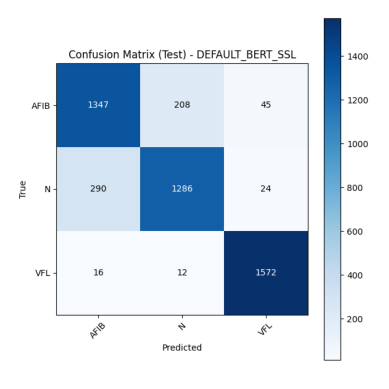

Finished. Outputs saved inside BERT_SSL_RHYTHM/Default_BERT_SSL folder.


In [10]:
print('\n' + '='*80)
print('Starting DEFAULT BERT+SSL 5-Fold training...')
print('='*80)

default_cfg = DEFAULT_CONFIG
folds_default = run_5fold_training(default_cfg, default_run_name='default_bert_ssl')
summarize_folds(folds_default, 'DEFAULT_BERT_SSL')

all_preds = []
all_trues = []
for f, d in folds_default.items():
    all_preds.extend(d['preds'])
    all_trues.extend(d['trues'])

classification_report_and_cm(all_trues, all_preds, DEFAULT_CONFIG['dataset']['classes'], 'DEFAULT_BERT_SSL')

print('Finished. Outputs saved inside BERT_SSL_RHYTHM/Default_BERT_SSL folder.')


## 8.2. Hyperparameter Tuning BERT+SSL (Hyperparameter tuning + 5-Fold Training)

[I 2025-12-02 17:28:01,700] A new study created in memory with name: no-name-86a9dba3-e082-4540-bd78-45983187d0b8



Starting HYPERPARAMETER TUNING...


/tmp/ipykernel_20/745603123.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
/tmp/ipykernel_20/745603123.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-6, 1e-2)
/tmp/ipykernel_20/745603123.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  mlm_mask_ratio = trial.suggest_uniform('mlm_mask_ratio', 0.10, 0.25)
/tmp/ipykernel_20/745603123.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature w

Best trial: {'lr': 0.0001807613913642408, 'weight_decay': 0.0008952478564576711, 'hidden_dim': 64, 'n_heads': 2, 'mlm_mask_ratio': 0.15746813425362743, 'ssl_weight': 0.717718385700964, 'temperature': 0.134888888467453}
Running 5-fold with HPO best config...

Starting fold 1 - BERT+SSL Training

--- Phase 1: SSL Pretraining (20 epochs) ---
Pretrain Epoch 1/20: contrastive_loss=3.7095 mlm_loss=0.0676
Pretrain Epoch 2/20: contrastive_loss=2.2338 mlm_loss=0.0282
Pretrain Epoch 3/20: contrastive_loss=1.6181 mlm_loss=0.0228
Pretrain Epoch 4/20: contrastive_loss=1.3266 mlm_loss=0.0158
Pretrain Epoch 5/20: contrastive_loss=1.1057 mlm_loss=0.0122
Pretrain Epoch 6/20: contrastive_loss=1.0327 mlm_loss=0.0099
Pretrain Epoch 7/20: contrastive_loss=0.9382 mlm_loss=0.0087
Pretrain Epoch 8/20: contrastive_loss=0.9121 mlm_loss=0.0075
Pretrain Epoch 9/20: contrastive_loss=0.8531 mlm_loss=0.0063
Pretrain Epoch 10/20: contrastive_loss=0.8059 mlm_loss=0.0056
Pretrain Epoch 11/20: contrastive_loss=0.8107 ml

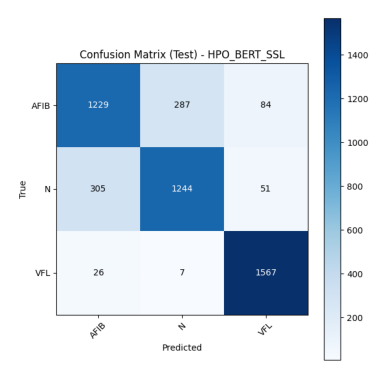

Finished. Outputs saved inside BERT_SSL_RHYTHM/HPO_BERT_SSL folder.

=== Comparison ===
DEFAULT mean acc: 0.8760416666666666
HPO mean acc: 0.8416666666666666

BERT+SSL TRAINING COMPLETED


In [11]:
if OPTUNA_AVAILABLE:
    print('\n' + '='*80)
    print('Starting HYPERPARAMETER TUNING...')
    print('='*80)
    hpo_cfg = json.loads(json.dumps(DEFAULT_CONFIG))
    hpo_cfg, study = run_hyperparam_search(hpo_cfg, n_trials=20, timeout=600)
    print('Running 5-fold with HPO best config...')
    folds_hpo = run_5fold_training(hpo_cfg, default_run_name='hpo_bert_ssl')
    summarize_folds(folds_hpo, 'HPO_BERT_SSL')

    all_preds_hpo = []
    all_trues_hpo = []
    for f, d in folds_hpo.items():
        all_preds_hpo.extend(d['preds'])
        all_trues_hpo.extend(d['trues'])
    classification_report_and_cm(all_trues_hpo, all_preds_hpo, DEFAULT_CONFIG['dataset']['classes'], 'HPO_BERT_SSL')
    
    print('Finished. Outputs saved inside BERT_SSL_RHYTHM/HPO_BERT_SSL folder.')
    
    print('\n=== Comparison ===')
    print('DEFAULT mean acc:', np.mean([d['val_acc'] for d in folds_default.values()]))
    print('HPO mean acc:', np.mean([d['val_acc'] for d in folds_hpo.values()]))
else:
    print('Optuna not available. Skipping HPO run. To enable, install optuna.')


print("\n" + "="*80)
print("BERT+SSL TRAINING COMPLETED")
print("="*80)

In [12]:
print('\n=== Comparison ===')
print('DEFAULT mean acc:', np.mean([d['val_acc'] for d in folds_default.values()]))
print('HPO mean acc:', np.mean([d['val_acc'] for d in folds_hpo.values()]))


=== Comparison ===
DEFAULT mean acc: 0.8760416666666666
HPO mean acc: 0.8416666666666666


# 9. Evaluate

## 9.1. Evaluate Utils

In [13]:
def plot_training_history_per_fold(fold_results, model_name, save_prefix):
    """Plot training history (loss and accuracy) for each fold separately"""
    history_dir = OUTPUT_DIRS['default_history'] if save_prefix.lower() == 'default_bert_ssl' else \
        OUTPUT_DIRS['hpo_history'] if save_prefix.lower() == 'hpo_bert_ssl' else OUTPUT_DIRS['outputs']
    
    n_folds = len(fold_results)
    
    fig, axes = plt.subplots(2, n_folds, figsize=(5*n_folds, 10))
    if n_folds == 1:
        axes = axes.reshape(-1, 1)
    
    fig.suptitle(f'{model_name} - Training History per Fold\n\n', fontsize=16, y=0.95)
    
    for i, (fold_num, fold_data) in enumerate(fold_results.items()):
        history = fold_data['history']
        epochs = range(1, len(history['train_loss']) + 1)
        
        # Plot Loss
        axes[0, i].plot(epochs, history['train_loss'], 'b-', label='Train Loss', marker='o', markersize=3)
        axes[0, i].plot(epochs, history['val_loss'], 'red', label='Val Loss', marker='s', markersize=3)
        axes[0, i].set_title(f'Fold {fold_num} - Loss')
        axes[0, i].set_xlabel('Epoch')
        axes[0, i].set_ylabel('Loss')
        axes[0, i].legend()
        axes[0, i].grid(True, alpha=0.3)
        
        # Plot Accuracy
        axes[1, i].plot(epochs, history['train_acc'], 'b-', label='Train Acc', marker='o', markersize=3)
        axes[1, i].plot(epochs, history['val_acc'], 'red', label='Val Acc', marker='s', markersize=3)
        axes[1, i].set_title(f'Fold {fold_num} - Accuracy')
        axes[1, i].set_xlabel('Epoch')
        axes[1, i].set_ylabel('Accuracy')
        axes[1, i].legend()
        axes[1, i].grid(True, alpha=0.3)
        axes[1, i].set_ylim(0, 1)
    
    plt.tight_layout()
    plt.savefig(f'{history_dir}/{save_prefix}_training_history_per_fold.png', dpi=300, bbox_inches='tight')
    plt.close()


def get_fold_predictions_detailed(fold_results, cfg, fold_num, dataset_type='train'):
    """Get predictions and true labels for a specific fold and dataset type"""
    device = cfg['training']['device']
    dataset = ECGRhythmDataset(cfg['dataset']['train_dirs'], cfg['dataset']['classes'])
    
    X = list(range(len(dataset)))
    y = dataset.labels
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=cfg['seed'])
    
    for current_fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
        if current_fold + 1 == fold_num:
            if dataset_type == 'train':
                subset_idx = train_idx
            else:
                subset_idx = val_idx
                
            subset = Subset(dataset, subset_idx)
            loader = DataLoader(subset, batch_size=cfg['training']['batch_size'], 
                              shuffle=False, collate_fn=collate_ecg, 
                              num_workers=cfg['training']['num_workers'])
            
            sample_x, _ = dataset[subset_idx[0]]
            L = sample_x.shape[0]
            patch_size = cfg['model']['patch_size']
            num_patches = (L + patch_size - 1) // patch_size
            
            model = BERT_SSL(num_patches=num_patches, patch_size=patch_size, cfg=cfg['model']).to(device)
            model.load_state_dict(fold_results[fold_num]['model_state_dict'])
            
            _, _, preds, trues = validate(model, loader, device)
            return preds, trues
    
    return [], []


def plot_confusion_matrix_heatmap(y_true, y_pred, classes, title, save_path, cmap='Blues'):
    """Create confusion matrix heatmap"""
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap, 
                xticklabels=classes, yticklabels=classes,
                cbar_kws={'label': 'Count'})
    
    plt.title(title, fontsize=14, pad=20)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.close()
    
    return cm


def generate_classification_reports_per_fold(fold_results, cfg, classes, model_name, save_prefix):
    """Generate classification reports for each fold (train and validation)"""
    reports = {
        'train': {},
        'val': {}
    }
    
    print(f"\n{'='*80}")
    print(f"{model_name} - CLASSIFICATION REPORTS PER FOLD")
    print('='*80)
    
    for fold_num in fold_results.keys():
        print(f"\n### FOLD {fold_num} ###")
        
        train_preds, train_trues = get_fold_predictions_detailed(fold_results, cfg, fold_num, 'train')
        if len(train_preds) > 0:
            train_report = classification_report(train_trues, train_preds, target_names=classes, output_dict=True)
            reports['train'][fold_num] = train_report
            
            print(f"\n--- FOLD {fold_num} TRAIN CLASSIFICATION REPORT ---")
            print(classification_report(train_trues, train_preds, target_names=classes))
        
        val_preds = fold_results[fold_num]['preds']
        val_trues = fold_results[fold_num]['trues']
        val_report = classification_report(val_trues, val_preds, target_names=classes, output_dict=True)
        reports['val'][fold_num] = val_report
        
        print(f"\n--- FOLD {fold_num} VALIDATION CLASSIFICATION REPORT ---")
        print(classification_report(val_trues, val_preds, target_names=classes))
    
    return reports


def generate_confusion_matrices_per_fold(fold_results, cfg, classes, model_name, save_prefix):
    """Generate confusion matrix for each fold (train and validation)"""
    print(f"\n{'='*80}")
    print(f"{model_name} - CONFUSION MATRIX PER FOLD")
    print('='*80)
    
    confusion_matrices = {
        'train': {},
        'val': {}
    }
    
    matrix_dir = OUTPUT_DIRS['default_matrix'] if save_prefix.lower() == 'default_bert_ssl' else \
        OUTPUT_DIRS['hpo_matrix'] if save_prefix.lower() == 'hpo_bert_ssl' else 'outputs'
    
    for fold_num in fold_results.keys():
        print(f"\n### FOLD {fold_num} CONFUSION MATRIX ###")
        
        train_preds, train_trues = get_fold_predictions_detailed(fold_results, cfg, fold_num, 'train')
        if len(train_preds) > 0:
            train_cm = plot_confusion_matrix_heatmap(
                train_trues, train_preds, classes,
                f'{model_name} - Fold {fold_num} Train Confusion Matrix',
                f'{matrix_dir}/{save_prefix}_fold{fold_num}_train_confusion_matrix.png',
                cmap='Blues'
            )
            confusion_matrices['train'][fold_num] = train_cm
            print(f"Fold {fold_num} Train Confusion Matrix saved")
            
            img = mpimg.imread(f'{matrix_dir}/{save_prefix}_fold{fold_num}_train_confusion_matrix.png')
            plt.imshow(img)
            plt.axis('off')
            plt.show()
        
        val_preds = fold_results[fold_num]['preds']
        val_trues = fold_results[fold_num]['trues']
        val_cm = plot_confusion_matrix_heatmap(
            val_trues, val_preds, classes,
            f'{model_name} - Fold {fold_num} Validation Confusion Matrix',
            f'{matrix_dir}/{save_prefix}_fold{fold_num}_val_confusion_matrix.png',
            cmap='Blues'
        )
        confusion_matrices['val'][fold_num] = val_cm
        print(f"Fold {fold_num} Validation Confusion Matrix saved")
        
        img = mpimg.imread(f'{matrix_dir}/{save_prefix}_fold{fold_num}_val_confusion_matrix.png')
        plt.imshow(img)
        plt.axis('off')
        plt.show()
    
    return confusion_matrices


def evaluate_test_set_for_fold(model_path, cfg, test_dirs, classes, fold_num, model_name, save_prefix):
    """Evaluate a specific fold model on test set"""
    device = cfg['training']['device']
    
    matrix_dir = OUTPUT_DIRS['default_matrix'] if save_prefix.lower() == 'default_bert_ssl' else \
        OUTPUT_DIRS['hpo_matrix'] if save_prefix.lower() == 'hpo_bert_ssl' else 'outputs'
    
    test_dataset = ECGRhythmDataset(test_dirs, classes)
    test_loader = DataLoader(test_dataset, batch_size=cfg['training']['batch_size'], 
                            shuffle=False, collate_fn=collate_ecg, 
                            num_workers=cfg['training']['num_workers'])
    
    sample_x, _ = test_dataset[0]
    L = sample_x.shape[0]
    patch_size = cfg['model']['patch_size']
    num_patches = (L + patch_size - 1) // patch_size
    
    model = BERT_SSL(num_patches=num_patches, patch_size=patch_size, cfg=cfg['model']).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    
    test_loss, test_acc, test_preds, test_trues = validate(model, test_loader, device)
    
    print(f"\n--- FOLD {fold_num} TEST CLASSIFICATION REPORT ---")
    test_report = classification_report(test_trues, test_preds, target_names=classes)
    print(test_report)
    
    test_cm = plot_confusion_matrix_heatmap(
        test_trues, test_preds, classes,
        f'{model_name} - Fold {fold_num} Test Confusion Matrix',
        f'{matrix_dir}/{save_prefix}_fold{fold_num}_test_confusion_matrix.png',
        cmap='Blues'
    )
    print(f"Fold {fold_num} Test Confusion Matrix saved")
    
    img = mpimg.imread(f'{matrix_dir}/{save_prefix}_fold{fold_num}_test_confusion_matrix.png')
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    
    return {
        'loss': test_loss,
        'accuracy': test_acc,
        'predictions': test_preds,
        'true_labels': test_trues,
        'classification_report': classification_report(test_trues, test_preds, target_names=classes, output_dict=True),
        'confusion_matrix': test_cm
    }


def find_best_fold(fold_results):
    """Find best fold based on validation accuracy"""
    best_fold = None
    best_acc = 0
    
    for fold, data in fold_results.items():
        if data['val_acc'] > best_acc:
            best_acc = data['val_acc']
            best_fold = fold
    
    return best_fold, best_acc


def display_fold_metrics(fold_results, model_name):
    """Display metrics for each fold"""
    print(f"\n=== {model_name} - Metrics per Fold ===")
    print("Fold | Val Acc | Val Loss | Train Acc (Last) | Train Loss (Last)")
    print("-" * 70)
    
    for fold, data in fold_results.items():
        history = data['history']
        last_train_acc = history['train_acc'][-1] if history['train_acc'] else "N/A"
        last_train_loss = history['train_loss'][-1] if history['train_loss'] else "N/A"
        
        print(f"{fold:4d} | {data['val_acc']:7.4f} | {data['val_loss']:8.4f} | {last_train_acc:13.4f} | {last_train_loss:15.4f}")


def evaluate_model_on_test_set(model_path, cfg, test_dirs, classes):
    """Evaluate model on test set"""
    device = cfg['training']['device']
    
    test_dataset = ECGRhythmDataset(test_dirs, classes)
    test_loader = DataLoader(test_dataset, batch_size=cfg['training']['batch_size'], 
                            shuffle=False, collate_fn=collate_ecg, 
                            num_workers=cfg['training']['num_workers'])
    
    sample_x, _ = test_dataset[0]
    L = sample_x.shape[0]
    patch_size = cfg['model']['patch_size']
    num_patches = (L + patch_size - 1) // patch_size
    
    model = BERT_SSL(num_patches=num_patches, patch_size=patch_size, cfg=cfg['model']).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    
    test_loss, test_acc, test_preds, test_trues = validate(model, test_loader, device)
    
    return test_loss, test_acc, test_preds, test_trues


def get_train_predictions(fold_results, cfg):
    """Get predictions for training set from each fold"""
    device = cfg['training']['device']
    dataset = ECGRhythmDataset(cfg['dataset']['train_dirs'], cfg['dataset']['classes'])
    
    all_train_preds = []
    all_train_trues = []
    
    for fold, fold_data in fold_results.items():
        X = list(range(len(dataset)))
        y = dataset.labels
        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=cfg['seed'])
        
        for current_fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
            if current_fold + 1 == fold:
                train_subset = Subset(dataset, train_idx)
                train_loader = DataLoader(train_subset, batch_size=cfg['training']['batch_size'], 
                                        shuffle=False, collate_fn=collate_ecg, 
                                        num_workers=cfg['training']['num_workers'])
                
                sample_x, _ = dataset[train_idx[0]]
                L = sample_x.shape[0]
                patch_size = cfg['model']['patch_size']
                num_patches = (L + patch_size - 1) // patch_size
                
                model = BERT_SSL(num_patches=num_patches, patch_size=patch_size, cfg=cfg['model']).to(device)
                model.load_state_dict(fold_data['model_state_dict'])
                
                _, _, train_preds, train_trues = validate(model, train_loader, device)
                all_train_preds.extend(train_preds)
                all_train_trues.extend(train_trues)
                break
    
    return all_train_preds, all_train_trues


def compare_configurations(default_cfg, hpo_cfg=None, output_dir=None):
    """Compare default and HPO configurations"""
    print("\n=== Parameter Comparison ===")
    print("Parameter                | Default Config | Best HPO Config")
    print("-" * 60)
    
    data = []
    
    def add_row(param, default_value, hpo_value):
        data.append({
            'Parameter': param,
            'Default Config': default_value,
            'Best HPO Config': hpo_value if hpo_cfg else 'N/A'
        })
    
    add_row("Device", default_cfg['training']['device'], hpo_cfg['training']['device'] if hpo_cfg else None)
    add_row("Epoch", default_cfg['training']['num_epochs'], hpo_cfg['training']['num_epochs'] if hpo_cfg else None)
    add_row("Batch Size", default_cfg['training']['batch_size'], hpo_cfg['training']['batch_size'] if hpo_cfg else None)
    add_row("Learning Rate", default_cfg['training']['learning_rate'], hpo_cfg['training']['learning_rate'] if hpo_cfg else None)
    add_row("Weight Decay", default_cfg['training']['weight_decay'], hpo_cfg['training']['weight_decay'] if hpo_cfg else None)
    add_row("SSL Weight", default_cfg['training']['ssl_weight'], hpo_cfg['training']['ssl_weight'] if hpo_cfg else None)
    add_row("Hidden Dimension", default_cfg['model']['hidden_dim'], hpo_cfg['model']['hidden_dim'] if hpo_cfg else None)
    add_row("Number of Heads", default_cfg['model']['n_heads'], hpo_cfg['model']['n_heads'] if hpo_cfg else None)
    add_row("MLM Mask Ratio", default_cfg['model']['mlm_mask_ratio'], hpo_cfg['model']['mlm_mask_ratio'] if hpo_cfg else None)
    add_row("Temperature", default_cfg['model']['temperature'], hpo_cfg['model']['temperature'] if hpo_cfg else None)
    add_row("Dropout", default_cfg['model']['dropout'], hpo_cfg['model']['dropout'] if hpo_cfg else None)

    for row in data:
        print(f"{row['Parameter']:<24} | {str(row['Default Config']):14s} | {str(row['Best HPO Config']):15s}")

    if output_dir:
        os.makedirs(output_dir, exist_ok=True)
        output_path = os.path.join(output_dir, "parameter_comparison.xlsx")
        df = pd.DataFrame(data)
        df.to_excel(output_path, index=False)
        print(f"\n✅ Parameter comparison saved to: {output_path}")


def calculate_detailed_metrics(y_true, y_pred, classes):
    """Calculate detailed metrics: Accuracy, Sensitivity, Specificity, F1-Score"""
    precision, recall, f1, support = precision_recall_fscore_support(y_true, y_pred, average=None, labels=range(len(classes)))
    
    cm = confusion_matrix(y_true, y_pred)
    
    per_class_accuracy = []
    specificity = []
    
    for i in range(len(classes)):
        total = cm.sum()
        tp = cm[i, i]
        fn = cm[i, :].sum() - tp
        tn = cm.sum() - (cm[i, :].sum() + cm[:, i].sum() - cm[i, i])
        fp = cm[:, i].sum() - cm[i, i]
 
        per_class_acc = (tp + tn) / total if total > 0 else 0
        per_class_accuracy.append(per_class_acc)
        
        spec = tn / (tn + fp) if (tn + fp) > 0 else 0
        specificity.append(spec)
    
    overall_accuracy = np.mean(per_class_accuracy)
    
    macro_sensitivity = np.mean(recall)
    macro_specificity = np.mean(specificity)
    macro_f1 = np.mean(f1)
    
    return {
        'per_class': {
            'accuracy': per_class_accuracy,
            'sensitivity': recall,
            'specificity': specificity,
            'f1_score': f1
        },
        'overall': {
            'accuracy': overall_accuracy,
            'sensitivity': macro_sensitivity,
            'specificity': macro_specificity,
            'f1_score': macro_f1
        }
    }


def get_test_metrics_for_best_fold(fold_results, cfg, classes, model_name, save_prefix):
    """Get test metrics for the best fold"""
    models_dir = OUTPUT_DIRS['default_models'] if save_prefix.lower() == 'default_bert_ssl' else \
        OUTPUT_DIRS['hpo_models'] if save_prefix.lower() == 'hpo_bert_ssl' else OUTPUT_DIRS['outputs']
    
    best_fold = None
    best_acc = 0
    for fold, data in fold_results.items():
        if data['val_acc'] > best_acc:
            best_acc = data['val_acc']
            best_fold = fold
    
    if best_fold is None:
        return None, None
        
    device = cfg['training']['device']
    test_dataset = ECGRhythmDataset(cfg['dataset']['test_dirs'], classes)
    test_loader = DataLoader(test_dataset, batch_size=cfg['training']['batch_size'], 
                            shuffle=False, collate_fn=collate_ecg, 
                            num_workers=cfg['training']['num_workers'])
    
    sample_x, _ = test_dataset[0]
    L = sample_x.shape[0]
    patch_size = cfg['model']['patch_size']
    num_patches = (L + patch_size - 1) // patch_size
    
    model = BERT_SSL(num_patches=num_patches, patch_size=patch_size, cfg=cfg['model']).to(device)
    model_path = f'{models_dir}/{save_prefix}_fold{best_fold}.pth'
    model.load_state_dict(torch.load(model_path, map_location=device))
    
    _, _, test_preds, test_trues = validate(model, test_loader, device)
    
    metrics = calculate_detailed_metrics(test_trues, test_preds, classes)
    
    results = []
    
    for i, class_name in enumerate(classes):
        results.append({
            'Best_Fold': best_fold,
            'Class': class_name,
            'Accuracy': f"{metrics['per_class']['accuracy'][i]:.4f}",
            'Sensitivity': f"{metrics['per_class']['sensitivity'][i]:.4f}",
            'Specificity': f"{metrics['per_class']['specificity'][i]:.4f}",
            'F1-Score': f"{metrics['per_class']['f1_score'][i]:.4f}"
        })
    
    results.append({
        'Best_Fold': best_fold,
        'Class': 'All',
        'Accuracy': f"{metrics['overall']['accuracy']:.4f}",
        'Sensitivity': f"{metrics['overall']['sensitivity']:.4f}",
        'Specificity': f"{metrics['overall']['specificity']:.4f}",
        'F1-Score': f"{metrics['overall']['f1_score']:.4f}"
    })
    
    return pd.DataFrame(results), best_fold


def create_detailed_metrics_table(fold_results, cfg, model_name, classes):
    """Create detailed metrics table for all folds"""
    results = []
    
    for fold_num in fold_results.keys():
        print(f"Processing {model_name} - Fold {fold_num}...")
        
        train_preds, train_trues = get_fold_predictions_detailed(fold_results, cfg, fold_num, 'train')
        
        if len(train_preds) > 0 and len(train_trues) > 0:
            metrics = calculate_detailed_metrics(train_trues, train_preds, classes)
            
            for i, class_name in enumerate(classes):
                results.append({
                    'Fold': f'Fold {fold_num}',
                    'Class': class_name,
                    'Accuracy': f"{metrics['per_class']['accuracy'][i]:.4f}",
                    'Sensitivity': f"{metrics['per_class']['sensitivity'][i]:.4f}",
                    'Specificity': f"{metrics['per_class']['specificity'][i]:.4f}",
                    'F1-Score': f"{metrics['per_class']['f1_score'][i]:.4f}"
                })
            
            results.append({
                'Fold': f'Fold {fold_num}',
                'Class': 'All',
                'Accuracy': f"{metrics['overall']['accuracy']:.4f}",
                'Sensitivity': f"{metrics['overall']['sensitivity']:.4f}",
                'Specificity': f"{metrics['overall']['specificity']:.4f}",
                'F1-Score': f"{metrics['overall']['f1_score']:.4f}"
            })
    
    all_train_preds = []
    all_train_trues = []
    
    for fold_num in fold_results.keys():
        train_preds, train_trues = get_fold_predictions_detailed(fold_results, cfg, fold_num, 'train')
        all_train_preds.extend(train_preds)
        all_train_trues.extend(train_trues)
    
    if len(all_train_preds) > 0:
        overall_metrics = calculate_detailed_metrics(all_train_trues, all_train_preds, classes)
        results.append({
            'Fold': 'Across 5 folds',
            'Class': 'All',
            'Accuracy': f"{overall_metrics['overall']['accuracy']:.4f}",
            'Sensitivity': f"{overall_metrics['overall']['sensitivity']:.4f}",
            'Specificity': f"{overall_metrics['overall']['specificity']:.4f}",
            'F1-Score': f"{overall_metrics['overall']['f1_score']:.4f}"
        })
    
    return pd.DataFrame(results)


def display_metrics_table(df, title):
    """Display metrics table in a formatted way"""
    print(f"\n{'='*80}")
    print(f"{title:^80}")
    print('='*80)
    
    current_fold = None
    for _, row in df.iterrows():
        if row['Fold'] != current_fold:
            if current_fold is not None:
                print('-'*80)
            current_fold = row['Fold']
            print(f"\n{row['Fold']:<15} {row['Class']:<5} {row['Accuracy']:<10} {row['Sensitivity']:<12} {row['Specificity']:<12} {row['F1-Score']:<10}")
        else:
            print(f"{'':15} {row['Class']:<5} {row['Accuracy']:<10} {row['Sensitivity']:<12} {row['Specificity']:<12} {row['F1-Score']:<10}")


def save_metrics_to_excel_enhanced(df_default, df_hpo=None, fold_results_default=None, fold_results_hpo=None, 
                                   default_cfg=None, hpo_cfg=None, classes=None, 
                                   filename=f'{OUTPUT_DIRS["outputs"]}/detailed_metrics_comparison.xlsx'):
    """Save metrics tables to Excel file with test results for best folds"""
    
    with pd.ExcelWriter(filename, engine='openpyxl') as writer:
        df_default.to_excel(writer, sheet_name='Default_Train_BERT_SSL', index=False)
        if df_hpo is not None:
            df_hpo.to_excel(writer, sheet_name='Tuning_Train_BERT_SSL', index=False)
        
        if fold_results_default is not None and default_cfg is not None and classes is not None:
            print("Generating Default_Test_BERT_SSL sheet...")
            df_default_test, best_fold_default = get_test_metrics_for_best_fold(
                fold_results_default, default_cfg, classes, "Default BERT+SSL", "default_bert_ssl"
            )
            if df_default_test is not None:
                df_default_test.to_excel(writer, sheet_name='Default_Test_BERT_SSL', index=False)
                print(f"Default_Test_BERT_SSL sheet created for best fold {best_fold_default}.")
        
        if fold_results_hpo is not None and hpo_cfg is not None and classes is not None:
            print("Generating Tuning_Test_BERT_SSL sheet...")
            df_hpo_test, best_fold_hpo = get_test_metrics_for_best_fold(
                fold_results_hpo, hpo_cfg, classes, "HPO BERT+SSL", "hpo_bert_ssl"
            )
            if df_hpo_test is not None:
                df_hpo_test.to_excel(writer, sheet_name='Tuning_Test_BERT_SSL', index=False)
                print(f"Tuning_Test_BERT_SSL sheet created for best fold {best_fold_hpo}.")
    
    print(f"Enhanced metrics saved to {filename}")


## 9.2. Best Fold - Default BERT+SSL & HPO BERT+SSL

In [14]:
best_fold_default, best_acc_default = find_best_fold(folds_default)
print(f"\n=> Best Fold (Default BERT+SSL): Fold {best_fold_default} with accuracy {best_acc_default:.4f}")

display_fold_metrics(folds_default, "DEFAULT BERT+SSL")

best_model_path = f'{OUTPUT_DIRS["default_models"]}/default_bert_ssl_fold{best_fold_default}.pth'
test_loss_default, test_acc_default, test_preds_default, test_trues_default = evaluate_model_on_test_set(
    best_model_path, default_cfg, DEFAULT_CONFIG['dataset']['test_dirs'], DEFAULT_CONFIG['dataset']['classes']
)

print(f"\nTest Accuracy Default BERT+SSL: {test_acc_default:.4f}")
print(f"Test Loss Default BERT+SSL: {test_loss_default:.4f}")

if OPTUNA_AVAILABLE and 'folds_hpo' in locals():
    best_fold_hpo, best_acc_hpo = find_best_fold(folds_hpo)
    print(f"\n=> Best Fold (HPO BERT+SSL): Fold {best_fold_hpo} with accuracy {best_acc_hpo:.4f}")
    
    display_fold_metrics(folds_hpo, "HPO BERT+SSL")

    best_model_path_hpo = f'{OUTPUT_DIRS["hpo_models"]}/hpo_bert_ssl_fold{best_fold_hpo}.pth'
    test_loss_hpo, test_acc_hpo, test_preds_hpo, test_trues_hpo = evaluate_model_on_test_set(
        best_model_path_hpo, hpo_cfg, DEFAULT_CONFIG['dataset']['test_dirs'], DEFAULT_CONFIG['dataset']['classes']
    )
    
    print(f"\nTest Accuracy HPO BERT+SSL: {test_acc_hpo:.4f}")
    print(f"Test Loss HPO BERT+SSL: {test_loss_hpo:.4f}")
    
    print(f"\n\n=== IMPROVEMENT SUMMARY ===")
    print(f"Improvement: {((best_acc_hpo - best_acc_default) / best_acc_default * 100):+.2f}% (validation)")
    print(f"Improvement: {((test_acc_hpo - test_acc_default) / test_acc_default * 100):+.2f}% (test)\n")



=> Best Fold (Default BERT+SSL): Fold 4 with accuracy 0.8917

=== DEFAULT BERT+SSL - Metrics per Fold ===
Fold | Val Acc | Val Loss | Train Acc (Last) | Train Loss (Last)
----------------------------------------------------------------------
   1 |  0.8906 |   0.3275 |        0.9563 |          0.1109
   2 |  0.8688 |   0.4181 |        0.9612 |          0.1000
   3 |  0.8729 |   0.4025 |        0.9487 |          0.1359
   4 |  0.8917 |   0.3102 |        0.9409 |          0.1435
   5 |  0.8562 |   0.3692 |        0.9453 |          0.1517

Test Accuracy Default BERT+SSL: 0.8850
Test Loss Default BERT+SSL: 0.3160

=> Best Fold (HPO BERT+SSL): Fold 1 with accuracy 0.8656

=== HPO BERT+SSL - Metrics per Fold ===
Fold | Val Acc | Val Loss | Train Acc (Last) | Train Loss (Last)
----------------------------------------------------------------------
   1 |  0.8656 |   0.3462 |        0.8633 |          0.3057
   2 |  0.8219 |   0.3931 |        0.8391 |          0.3618
   3 |  0.8375 |   0.3742 |

## 9.3. Training History per Fold - Default BERT+SSL & HPO BERT+SSL


Generating training history Default BERT+SSL plots per fold...


Default BERT+SSL - Training History per Fold:


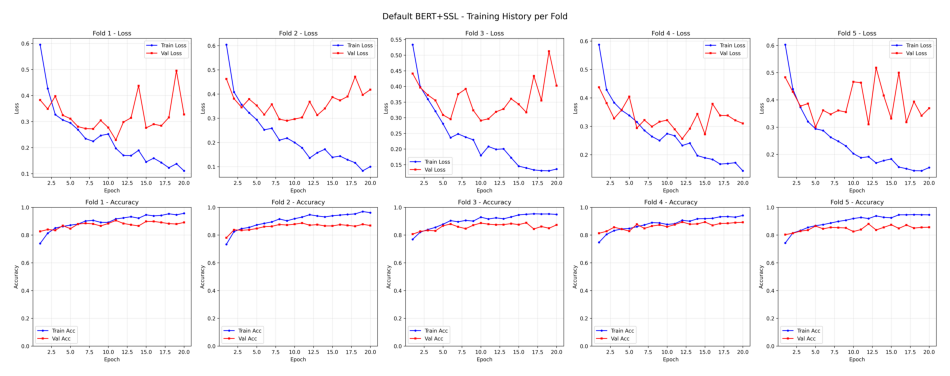

Generating training history HPO BERT+SSL plots per fold...


HPO BERT+SSL - Training History per Fold:


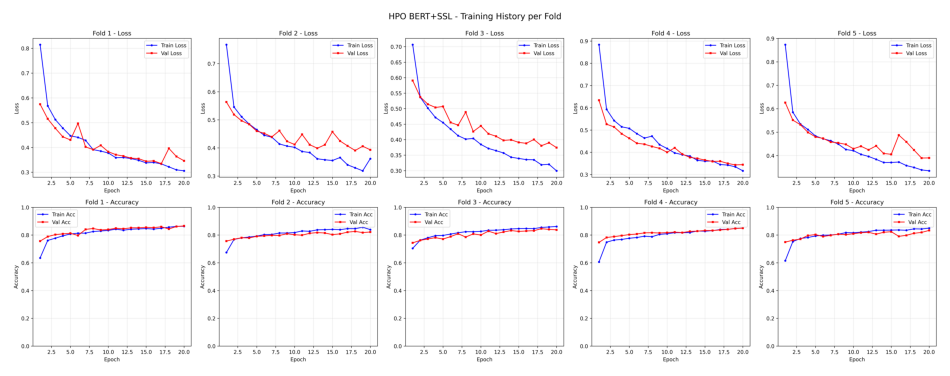

In [15]:
print("\nGenerating training history Default BERT+SSL plots per fold...")
plot_training_history_per_fold(folds_default, 'Default BERT+SSL', 'default_bert_ssl')

print("\n\nDefault BERT+SSL - Training History per Fold:")
img = mpimg.imread(f'{OUTPUT_DIRS["default_history"]}/default_bert_ssl_training_history_per_fold.png')
plt.figure(figsize=(12, 12)) 
plt.imshow(img)
plt.axis('off')
plt.show()

if OPTUNA_AVAILABLE and 'folds_hpo' in locals():
    print("Generating training history HPO BERT+SSL plots per fold...")
    plot_training_history_per_fold(folds_hpo, 'HPO BERT+SSL', 'hpo_bert_ssl')

    print("\n\nHPO BERT+SSL - Training History per Fold:")
    img = mpimg.imread(f'{OUTPUT_DIRS["hpo_history"]}/hpo_bert_ssl_training_history_per_fold.png')
    plt.figure(figsize=(12, 12)) 
    plt.imshow(img)
    plt.axis('off')
    plt.show()

## 9.4. Classification Report per Fold - Default BERT+SSL & HPO BERT+SSL

In [16]:
print("\nGenerating classification Default BERT+SSL reports per fold...")
reports_default = generate_classification_reports_per_fold(
    folds_default, default_cfg, DEFAULT_CONFIG['dataset']['classes'], 'Default BERT+SSL', 'default_bert_ssl'
)

if OPTUNA_AVAILABLE and 'folds_hpo' in locals():
    print("\nGenerating classification HPO BERT+SSL reports per fold...")
    reports_hpo = generate_classification_reports_per_fold(
        folds_hpo, hpo_cfg, DEFAULT_CONFIG['dataset']['classes'], 'HPO BERT+SSL', 'hpo_bert_ssl'
    )



Generating classification Default BERT+SSL reports per fold...

Default BERT+SSL - CLASSIFICATION REPORTS PER FOLD

### FOLD 1 ###

--- FOLD 1 TRAIN CLASSIFICATION REPORT ---
              precision    recall  f1-score   support

        AFIB       0.95      0.99      0.97      1280
           N       0.99      0.94      0.96      1280
         VFL       0.99      1.00      1.00      1280

    accuracy                           0.98      3840
   macro avg       0.98      0.98      0.98      3840
weighted avg       0.98      0.98      0.98      3840


--- FOLD 1 VALIDATION CLASSIFICATION REPORT ---
              precision    recall  f1-score   support

        AFIB       0.83      0.87      0.85       320
           N       0.90      0.81      0.85       320
         VFL       0.94      0.99      0.96       320

    accuracy                           0.89       960
   macro avg       0.89      0.89      0.89       960
weighted avg       0.89      0.89      0.89       960


### FOLD 2 #

## 9.5.  Confusion Matrix per Fold - Default BERT+SSL & HPO BERT+SSL


Generating Confusion Matrix Default BERT+SSL per fold...

Default BERT+SSL - CONFUSION MATRIX PER FOLD

### FOLD 1 CONFUSION MATRIX ###
Fold 1 Train Confusion Matrix saved


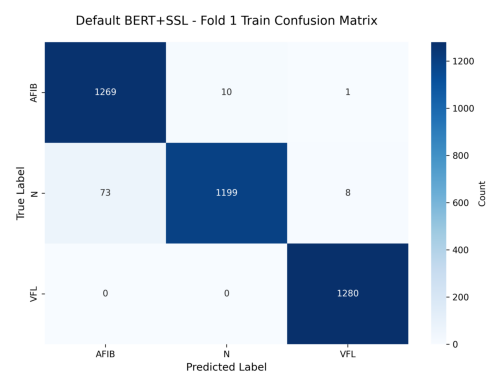

Fold 1 Validation Confusion Matrix saved


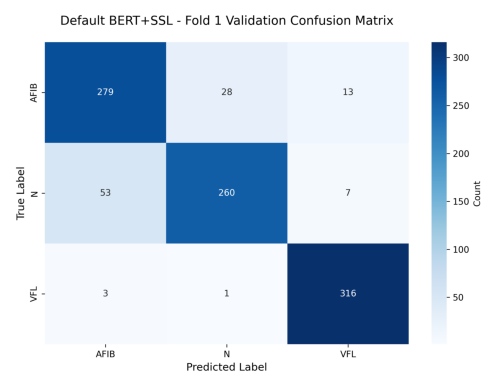


### FOLD 2 CONFUSION MATRIX ###
Fold 2 Train Confusion Matrix saved


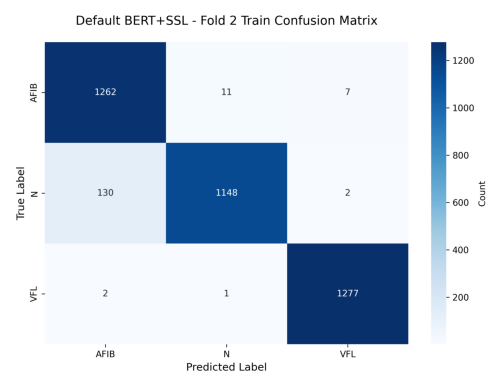

Fold 2 Validation Confusion Matrix saved


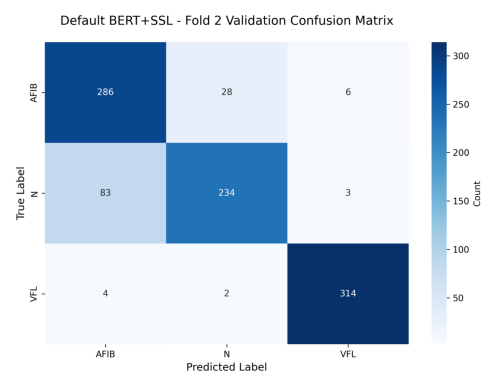


### FOLD 3 CONFUSION MATRIX ###
Fold 3 Train Confusion Matrix saved


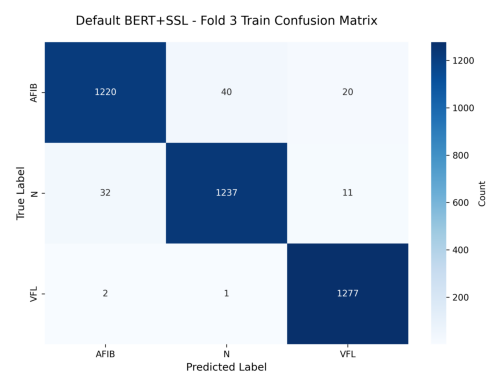

Fold 3 Validation Confusion Matrix saved


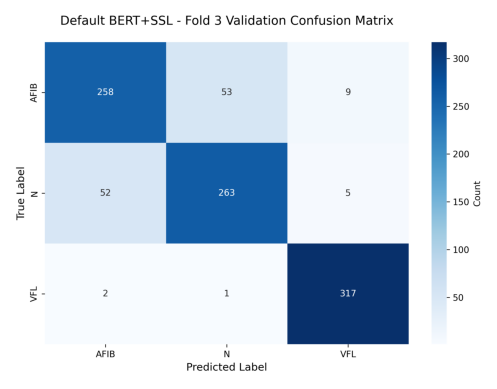


### FOLD 4 CONFUSION MATRIX ###
Fold 4 Train Confusion Matrix saved


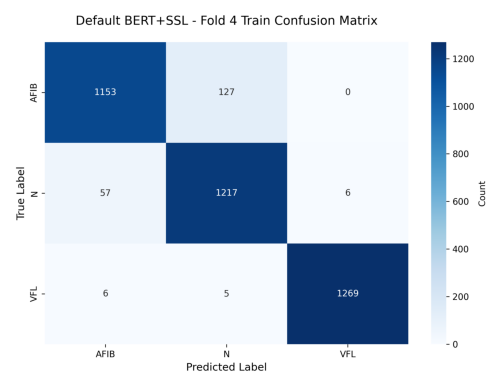

Fold 4 Validation Confusion Matrix saved


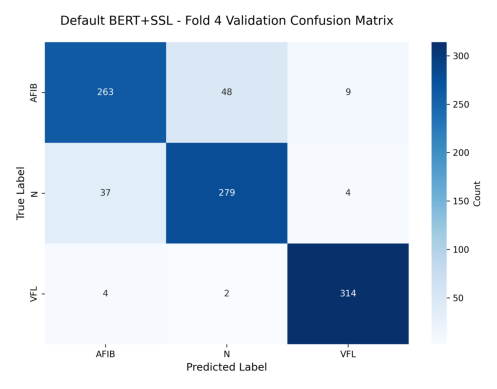


### FOLD 5 CONFUSION MATRIX ###
Fold 5 Train Confusion Matrix saved


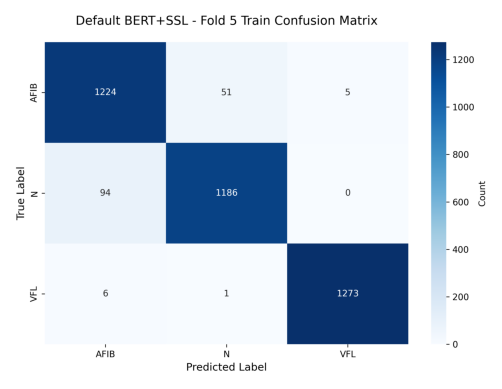

Fold 5 Validation Confusion Matrix saved


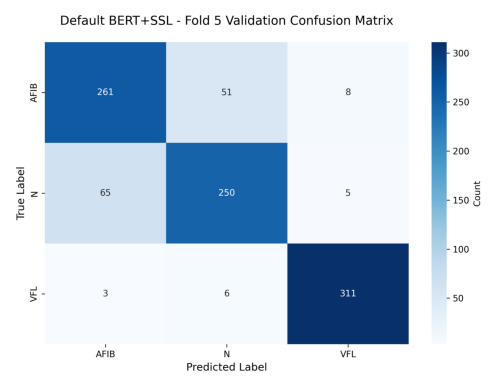


Generating Confusion Matrix HPO BERT+SSL per fold...

HPO BERT+SSL - CONFUSION MATRIX PER FOLD

### FOLD 1 CONFUSION MATRIX ###
Fold 1 Train Confusion Matrix saved


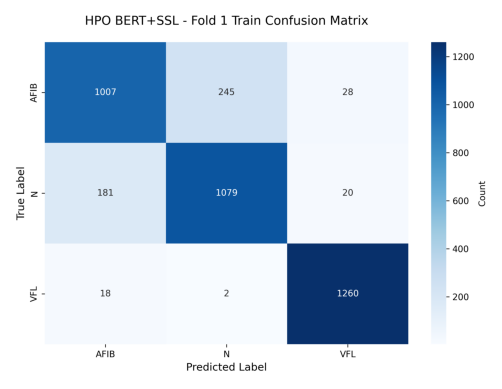

Fold 1 Validation Confusion Matrix saved


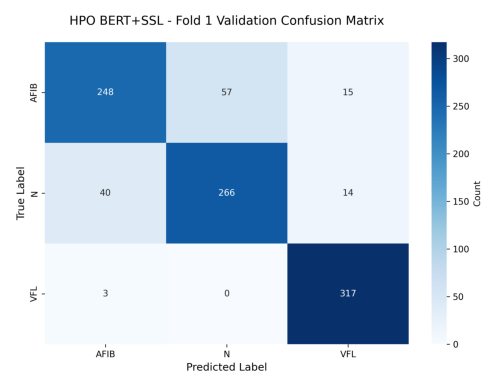


### FOLD 2 CONFUSION MATRIX ###
Fold 2 Train Confusion Matrix saved


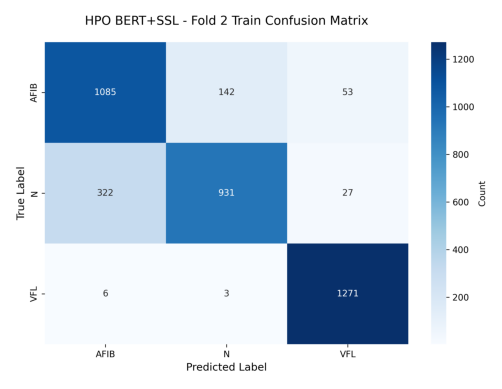

Fold 2 Validation Confusion Matrix saved


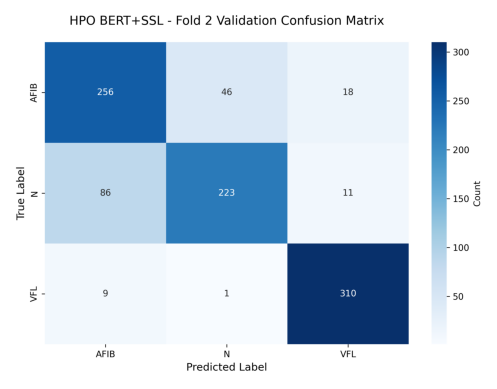


### FOLD 3 CONFUSION MATRIX ###
Fold 3 Train Confusion Matrix saved


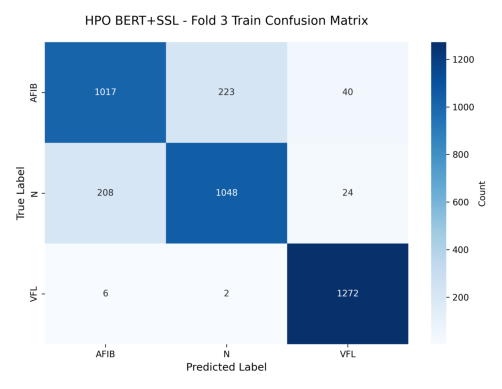

Fold 3 Validation Confusion Matrix saved


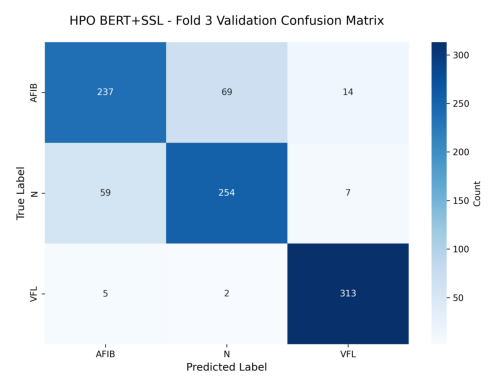


### FOLD 4 CONFUSION MATRIX ###
Fold 4 Train Confusion Matrix saved


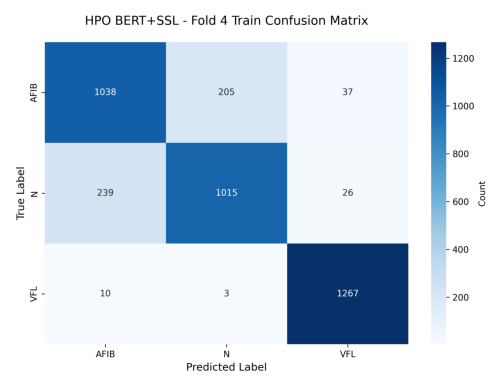

Fold 4 Validation Confusion Matrix saved


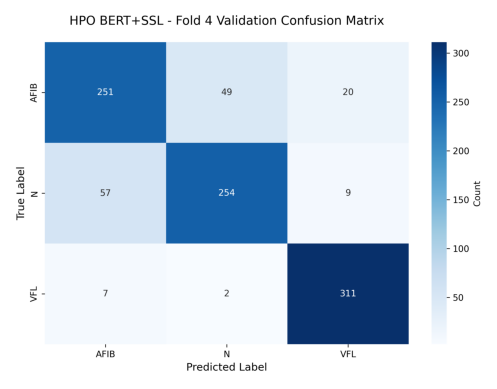


### FOLD 5 CONFUSION MATRIX ###
Fold 5 Train Confusion Matrix saved


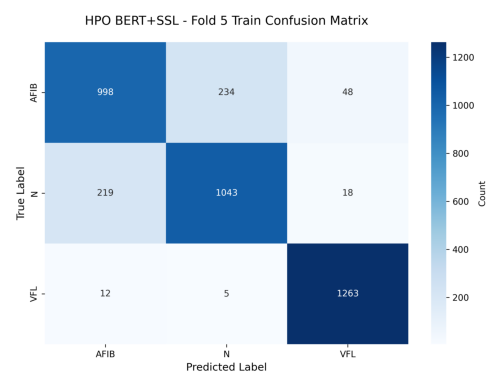

Fold 5 Validation Confusion Matrix saved


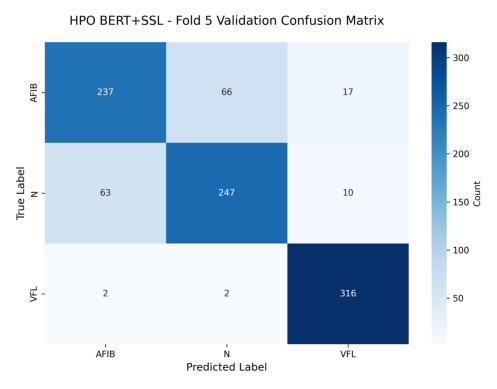

In [17]:
print("\nGenerating Confusion Matrix Default BERT+SSL per fold...")
cm_default = generate_confusion_matrices_per_fold(
    folds_default, default_cfg, DEFAULT_CONFIG['dataset']['classes'], 'Default BERT+SSL', 'default_bert_ssl'
)

if OPTUNA_AVAILABLE and 'folds_hpo' in locals():
    print("\nGenerating Confusion Matrix HPO BERT+SSL per fold...")
    cm_hpo = generate_confusion_matrices_per_fold(
        folds_hpo, hpo_cfg, DEFAULT_CONFIG['dataset']['classes'], 'HPO BERT+SSL', 'hpo_bert_ssl'
    )



## 9.6. Best Fold Default BERT+SSL & HPO BERT+SSL - Train & Test Evaluation

### 9.6.1. Default BERT


Getting train predictions for Default BERT+SSL...

--- Classification Report Train Default BERT+SSL ---
              precision    recall  f1-score   support

        AFIB       0.94      0.96      0.95      6400
           N       0.96      0.94      0.95      6400
         VFL       0.99      1.00      0.99      6400

    accuracy                           0.96     19200
   macro avg       0.96      0.96      0.96     19200
weighted avg       0.96      0.96      0.96     19200

Generating Confusion Matrix Train Default BERT+SSL...
Confusion Matrix Train Default BERT+SSL:



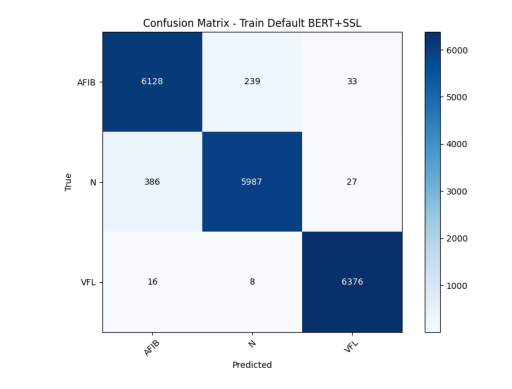


Evaluating Default BERT+SSL on test set...
Test Accuracy Default BERT+SSL: 0.8850
Test Loss Default BERT+SSL: 0.3160

--- Classification Report Test Default BERT+SSL ---
              precision    recall  f1-score   support

        AFIB       0.87      0.80      0.83       400
           N       0.82      0.88      0.85       400
         VFL       0.97      0.97      0.97       400

    accuracy                           0.89      1200
   macro avg       0.89      0.89      0.88      1200
weighted avg       0.89      0.89      0.88      1200

Generating Confusion Matrix Test Default BERT+SSL...
Confusion Matrix Test Default BERT+SSL:



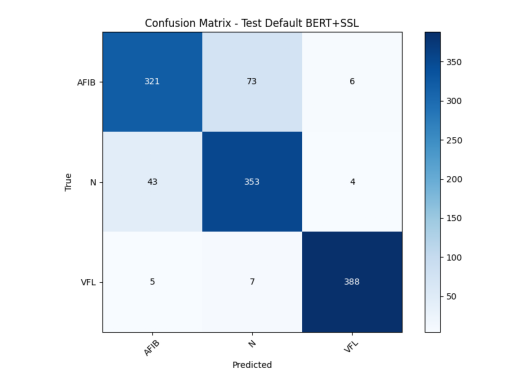

In [18]:
print("\nGetting train predictions for Default BERT+SSL...")
train_preds_default, train_trues_default = get_train_predictions(folds_default, default_cfg)

print("\n--- Classification Report Train Default BERT+SSL ---")
print(classification_report(train_trues_default, train_preds_default, target_names=DEFAULT_CONFIG['dataset']['classes']))

print("Generating Confusion Matrix Train Default BERT+SSL...")
cm_train_default = confusion_matrix(train_trues_default, train_preds_default)
print('Confusion Matrix Train Default BERT+SSL:\n')

plt.figure(figsize=(8,6))
plt.imshow(cm_train_default, interpolation='nearest', cmap='Blues')
plt.title('Confusion Matrix - Train Default BERT+SSL')
plt.colorbar()

for i in range(len(DEFAULT_CONFIG['dataset']['classes'])):
    for j in range(len(DEFAULT_CONFIG['dataset']['classes'])):
        plt.text(j, i, str(cm_train_default[i, j]),
                 ha="center", va="center",
                 color="white" if cm_train_default[i, j] > cm_train_default.max()/2 else "black")

tick_marks = np.arange(len(DEFAULT_CONFIG['dataset']['classes']))
plt.xticks(tick_marks, DEFAULT_CONFIG['dataset']['classes'], rotation=45)
plt.yticks(tick_marks, DEFAULT_CONFIG['dataset']['classes'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.savefig(f'{OUTPUT_DIRS["default_matrix"]}/train_default_bert_ssl_confusion_matrix.png')
plt.close()

img = mpimg.imread(f'{OUTPUT_DIRS["default_matrix"]}/train_default_bert_ssl_confusion_matrix.png')
plt.imshow(img)
plt.axis('off')
plt.show()

print("\nEvaluating Default BERT+SSL on test set...")
best_model_path = f'{OUTPUT_DIRS["default_models"]}/default_bert_ssl_fold{best_fold_default}.pth'
test_loss_default, test_acc_default, test_preds_default, test_trues_default = evaluate_model_on_test_set(
    best_model_path, default_cfg, DEFAULT_CONFIG['dataset']['test_dirs'], DEFAULT_CONFIG['dataset']['classes']
)

print(f"Test Accuracy Default BERT+SSL: {test_acc_default:.4f}")
print(f"Test Loss Default BERT+SSL: {test_loss_default:.4f}")

print("\n--- Classification Report Test Default BERT+SSL ---")
print(classification_report(test_trues_default, test_preds_default, target_names=DEFAULT_CONFIG['dataset']['classes']))

print("Generating Confusion Matrix Test Default BERT+SSL...")
cm_test_default = confusion_matrix(test_trues_default, test_preds_default)
print('Confusion Matrix Test Default BERT+SSL:\n')

plt.figure(figsize=(8,6))
plt.imshow(cm_test_default, interpolation='nearest', cmap='Blues')
plt.title('Confusion Matrix - Test Default BERT+SSL')
plt.colorbar()

for i in range(len(DEFAULT_CONFIG['dataset']['classes'])):
    for j in range(len(DEFAULT_CONFIG['dataset']['classes'])):
        plt.text(j, i, str(cm_test_default[i, j]),
                 ha="center", va="center",
                 color="white" if cm_test_default[i, j] > cm_test_default.max()/2 else "black")

tick_marks = np.arange(len(DEFAULT_CONFIG['dataset']['classes']))
plt.xticks(tick_marks, DEFAULT_CONFIG['dataset']['classes'], rotation=45)
plt.yticks(tick_marks, DEFAULT_CONFIG['dataset']['classes'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.savefig(f'{OUTPUT_DIRS["default_matrix"]}/test_default_bert_ssl_confusion_matrix.png')
plt.close()

img = mpimg.imread(f'{OUTPUT_DIRS["default_matrix"]}/test_default_bert_ssl_confusion_matrix.png')
plt.imshow(img)
plt.axis('off')
plt.show()

### 9.6.2. HPO BERT


Getting train predictions for HPO BERT+SSL...

--- Classification Report Train HPO BERT+SSL ---
              precision    recall  f1-score   support

        AFIB       0.81      0.80      0.81      6400
           N       0.83      0.80      0.81      6400
         VFL       0.95      0.99      0.97      6400

    accuracy                           0.86     19200
   macro avg       0.86      0.86      0.86     19200
weighted avg       0.86      0.86      0.86     19200

Generating Confusion Matrix Train HPO BERT+SSL...
Confusion Matrix Train HPO BERT+SSL:



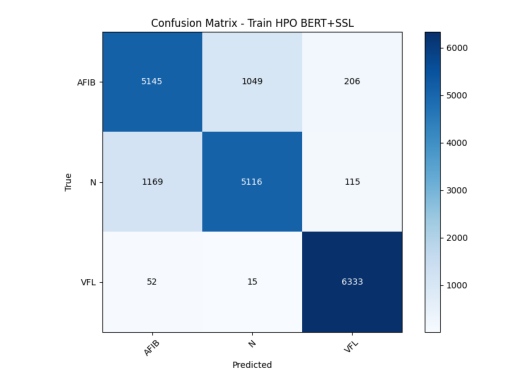


Evaluating HPO BERT+SSL on test set...
Test Accuracy HPO BERT+SSL: 0.8650
Test Loss HPO BERT+SSL: 0.3163

--- Classification Report Test HPO BERT+SSL ---
              precision    recall  f1-score   support

        AFIB       0.83      0.76      0.79       400
           N       0.81      0.85      0.83       400
         VFL       0.94      0.98      0.96       400

    accuracy                           0.86      1200
   macro avg       0.86      0.86      0.86      1200
weighted avg       0.86      0.86      0.86      1200

Generating Confusion Matrix Test HPO BERT+SSL...
Confusion Matrix Test HPO BERT+SSL:



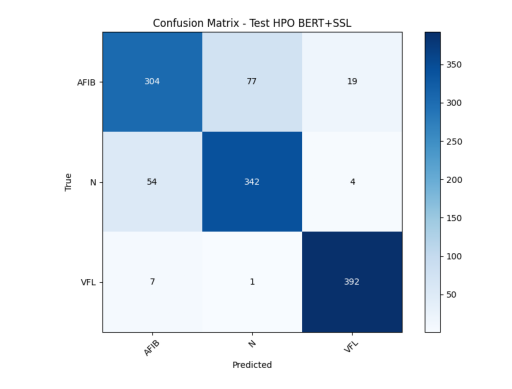

In [19]:
if OPTUNA_AVAILABLE and 'folds_hpo' in locals():
    print("\nGetting train predictions for HPO BERT+SSL...")
    train_preds_hpo, train_trues_hpo = get_train_predictions(folds_hpo, hpo_cfg)
    
    print("\n--- Classification Report Train HPO BERT+SSL ---")
    print(classification_report(train_trues_hpo, train_preds_hpo, target_names=DEFAULT_CONFIG['dataset']['classes']))
    
    print("Generating Confusion Matrix Train HPO BERT+SSL...")
    cm_train_hpo = confusion_matrix(train_trues_hpo, train_preds_hpo)
    print('Confusion Matrix Train HPO BERT+SSL:\n')
    
    plt.figure(figsize=(8,6))
    plt.imshow(cm_train_hpo, interpolation='nearest', cmap='Blues')
    plt.title('Confusion Matrix - Train HPO BERT+SSL')
    plt.colorbar()
    
    for i in range(len(DEFAULT_CONFIG['dataset']['classes'])):
        for j in range(len(DEFAULT_CONFIG['dataset']['classes'])):
            plt.text(j, i, str(cm_train_hpo[i, j]),
                     ha="center", va="center",
                     color="white" if cm_train_hpo[i, j] > cm_train_hpo.max()/2 else "black")
    
    tick_marks = np.arange(len(DEFAULT_CONFIG['dataset']['classes']))
    plt.xticks(tick_marks, DEFAULT_CONFIG['dataset']['classes'], rotation=45)
    plt.yticks(tick_marks, DEFAULT_CONFIG['dataset']['classes'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.savefig(f'{OUTPUT_DIRS["hpo_matrix"]}/train_hpo_bert_ssl_confusion_matrix.png')
    plt.close()

    img = mpimg.imread(f'{OUTPUT_DIRS["hpo_matrix"]}/train_hpo_bert_ssl_confusion_matrix.png')
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    
    print("\nEvaluating HPO BERT+SSL on test set...")
    best_model_path_hpo = f'{OUTPUT_DIRS["hpo_models"]}/hpo_bert_ssl_fold{best_fold_hpo}.pth'
    test_loss_hpo, test_acc_hpo, test_preds_hpo, test_trues_hpo = evaluate_model_on_test_set(
        best_model_path_hpo, hpo_cfg, DEFAULT_CONFIG['dataset']['test_dirs'], DEFAULT_CONFIG['dataset']['classes']
    )
    
    print(f"Test Accuracy HPO BERT+SSL: {test_acc_hpo:.4f}")
    print(f"Test Loss HPO BERT+SSL: {test_loss_hpo:.4f}")
    
    print("\n--- Classification Report Test HPO BERT+SSL ---")
    print(classification_report(test_trues_hpo, test_preds_hpo, target_names=DEFAULT_CONFIG['dataset']['classes']))
    
    print("Generating Confusion Matrix Test HPO BERT+SSL...")
    cm_test_hpo = confusion_matrix(test_trues_hpo, test_preds_hpo)
    print('Confusion Matrix Test HPO BERT+SSL:\n')
    
    plt.figure(figsize=(8,6))
    plt.imshow(cm_test_hpo, interpolation='nearest', cmap='Blues')
    plt.title('Confusion Matrix - Test HPO BERT+SSL')
    plt.colorbar()
    
    for i in range(len(DEFAULT_CONFIG['dataset']['classes'])):
        for j in range(len(DEFAULT_CONFIG['dataset']['classes'])):
            plt.text(j, i, str(cm_test_hpo[i, j]),
                     ha="center", va="center",
                     color="white" if cm_test_hpo[i, j] > cm_test_hpo.max()/2 else "black")
    
    tick_marks = np.arange(len(DEFAULT_CONFIG['dataset']['classes']))
    plt.xticks(tick_marks, DEFAULT_CONFIG['dataset']['classes'], rotation=45)
    plt.yticks(tick_marks, DEFAULT_CONFIG['dataset']['classes'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.savefig(f'{OUTPUT_DIRS["hpo_matrix"]}/test_hpo_bert_ssl_confusion_matrix.png')
    plt.close()

    img = mpimg.imread(f'{OUTPUT_DIRS["hpo_matrix"]}/test_hpo_bert_ssl_confusion_matrix.png')
    plt.imshow(img)
    plt.axis('off')
    plt.show()


## 9.7. Default BERT+SSL & HPO BERT+SSL - Parameter Comparison

In [20]:
if OPTUNA_AVAILABLE and 'folds_hpo' in locals():
    compare_configurations(default_cfg, hpo_cfg, output_dir=OUTPUT_DIRS['outputs'])
else:
    compare_configurations(default_cfg, None, output_dir=OUTPUT_DIRS['outputs'])


=== Parameter Comparison ===
Parameter                | Default Config | Best HPO Config
------------------------------------------------------------
Device                   | cuda           | cuda           
Epoch                    | 20             | 20             
Batch Size               | 64             | 64             
Learning Rate            | 0.001          | 0.0001807613913642408
Weight Decay             | 0.0001         | 0.0008952478564576711
SSL Weight               | 0.5            | 0.717718385700964
Hidden Dimension         | 128            | 64             
Number of Heads          | 4              | 2              
MLM Mask Ratio           | 0.15           | 0.15746813425362743
Temperature              | 0.07           | 0.134888888467453
Dropout                  | 0.1            | 0.1            

✅ Parameter comparison saved to: BERT_SSL_RHYTHM/parameter_comparison.xlsx


## 9.8. Export Detailed Metrics Table to Excel

In [21]:
print("\n" + "="*80)
print("GENERATING DETAILED METRICS TABLES")
print("="*80)

print("\nGenerating detailed metrics table for Default BERT+SSL...")
df_default_metrics = create_detailed_metrics_table(folds_default, default_cfg, "Default BERT+SSL", DEFAULT_CONFIG['dataset']['classes'])
display_metrics_table(df_default_metrics, "Default Train BERT+SSL Metrics")

df_hpo_metrics = None
fold_results_hpo_for_excel = None
hpo_cfg_for_excel = None

if OPTUNA_AVAILABLE and 'folds_hpo' in locals():
    print("\nGenerating detailed metrics table for HPO BERT+SSL...")
    df_hpo_metrics = create_detailed_metrics_table(folds_hpo, hpo_cfg, "HPO BERT+SSL", DEFAULT_CONFIG['dataset']['classes'])
    display_metrics_table(df_hpo_metrics, "Tuning Train BERT+SSL Metrics")
    fold_results_hpo_for_excel = folds_hpo
    hpo_cfg_for_excel = hpo_cfg

print("\nSaving enhanced Excel file with test results for best folds...")
save_metrics_to_excel_enhanced(
    df_default_metrics, 
    df_hpo_metrics, 
    fold_results_default=folds_default,
    fold_results_hpo=fold_results_hpo_for_excel,
    default_cfg=default_cfg,
    hpo_cfg=hpo_cfg_for_excel,
    classes=DEFAULT_CONFIG['dataset']['classes']
)

if df_hpo_metrics is not None:
    print(f"\n{'='*160}")
    print(f"{'SIDE-BY-SIDE COMPARISON':^160}")
    print('='*160)
    print(f"{'Default Train BERT+SSL':<80} {'Tuning Train BERT+SSL':<80}")
    print('-'*160)
    print(f"{'Fold':<8} {'Class':<5} {'Acc':<8} {'Sens':<8} {'Spec':<8} {'F1':<8} | {'Fold':<8} {'Class':<5} {'Acc':<8} {'Sens':<8} {'Spec':<8} {'F1':<8}")
    print('-'*160)
    
    max_rows = max(len(df_default_metrics), len(df_hpo_metrics))
    for i in range(max_rows):
        left_row = df_default_metrics.iloc[i] if i < len(df_default_metrics) else {'Fold': '', 'Class': '', 'Accuracy': '', 'Sensitivity': '', 'Specificity': '', 'F1-Score': ''}
        right_row = df_hpo_metrics.iloc[i] if i < len(df_hpo_metrics) else {'Fold': '', 'Class': '', 'Accuracy': '', 'Sensitivity': '', 'Specificity': '', 'F1-Score': ''}
        
        left_fold = left_row['Fold'].replace('Fold ', '') if 'Fold' in str(left_row['Fold']) else left_row['Fold']
        right_fold = right_row['Fold'].replace('Fold ', '') if 'Fold' in str(right_row['Fold']) else right_row['Fold']
        
        print(f"{left_fold:<8} {left_row['Class']:<5} {left_row['Accuracy']:<8} {left_row['Sensitivity']:<8} {left_row['Specificity']:<8} {left_row['F1-Score']:<8} | {right_fold:<8} {right_row['Class']:<5} {right_row['Accuracy']:<8} {right_row['Sensitivity']:<8} {right_row['Specificity']:<8} {right_row['F1-Score']:<8}")

print(f"\n{'='*80}")
print("DETAILED METRICS TABLE GENERATION COMPLETED")
print("Excel file includes the following sheets:")
print("1. Default_Train_BERT_SSL - All folds training metrics for Default BERT+SSL")
print("2. Tuning_Train_BERT_SSL - All folds training metrics for HPO BERT+SSL") 
print("3. Default_Test_BERT_SSL - Test metrics for best Default BERT+SSL fold")
print("4. Tuning_Test_BERT_SSL - Test metrics for best HPO BERT+SSL fold")
print('='*80)


# 11. Final Summary

print("\n" + "="*80)
print("BERT+SSL ECG RHYTHM CLASSIFICATION - FINAL SUMMARY")
print("="*80)

print(f"\n📊 Default BERT+SSL Results:")
print(f"   - Best Fold: {best_fold_default}")
print(f"   - Validation Accuracy: {best_acc_default:.4f}")
print(f"   - Test Accuracy: {test_acc_default:.4f}")

if OPTUNA_AVAILABLE and 'folds_hpo' in locals():
    print(f"\n📊 HPO BERT+SSL Results:")
    print(f"   - Best Fold: {best_fold_hpo}")
    print(f"   - Validation Accuracy: {best_acc_hpo:.4f}")
    print(f"   - Test Accuracy: {test_acc_hpo:.4f}")
    
    improvement_val = ((best_acc_hpo - best_acc_default) / best_acc_default * 100)
    improvement_test = ((test_acc_hpo - test_acc_default) / test_acc_default * 100)
    
    print(f"\n📈 Improvement with HPO:")
    print(f"   - Validation: {improvement_val:+.2f}%")
    print(f"   - Test: {improvement_test:+.2f}%")

print(f"\n📁 All outputs saved in: BERT_SSL_RHYTHM/")
print(f"   - Models: BERT_SSL_RHYTHM/Default_BERT_SSL/Model_Save/ and HPO_BERT_SSL/Model_Save/")
print(f"   - Visualizations: Training_History/ and Matrix/ folders")
print(f"   - Metrics: detailed_metrics_comparison.xlsx")
print(f"   - Configurations: config_default.json and config_hpo.json")

print("\n" + "="*80)
print("✅ BERT+SSL TRAINING AND EVALUATION COMPLETED SUCCESSFULLY!")
print("="*80)


GENERATING DETAILED METRICS TABLES

Generating detailed metrics table for Default BERT+SSL...
Processing Default BERT+SSL - Fold 1...
Processing Default BERT+SSL - Fold 2...
Processing Default BERT+SSL - Fold 3...
Processing Default BERT+SSL - Fold 4...
Processing Default BERT+SSL - Fold 5...

                         Default Train BERT+SSL Metrics                         

Fold 1          AFIB  0.9781     0.9914       0.9715       0.9680    
                N     0.9763     0.9367       0.9961       0.9634    
                VFL   0.9977     1.0000       0.9965       0.9965    
                All   0.9840     0.9760       0.9880       0.9760    
--------------------------------------------------------------------------------

Fold 2          AFIB  0.9609     0.9859       0.9484       0.9439    
                N     0.9625     0.8969       0.9953       0.9410    
                VFL   0.9969     0.9977       0.9965       0.9953    
                All   0.9734     0.9602       0.98

# 10. ZIP Output

In [22]:
for root, dirs, files in os.walk('/kaggle/working'):
    print(root)
    # for file in files:
    #     print("  └──", file)

/kaggle/working
/kaggle/working/BERT_SSL_RHYTHM
/kaggle/working/BERT_SSL_RHYTHM/HPO_BERT_SSL
/kaggle/working/BERT_SSL_RHYTHM/HPO_BERT_SSL/Matrix
/kaggle/working/BERT_SSL_RHYTHM/HPO_BERT_SSL/Training_History
/kaggle/working/BERT_SSL_RHYTHM/HPO_BERT_SSL/Model_Save
/kaggle/working/BERT_SSL_RHYTHM/Default_BERT_SSL
/kaggle/working/BERT_SSL_RHYTHM/Default_BERT_SSL/Matrix
/kaggle/working/BERT_SSL_RHYTHM/Default_BERT_SSL/Training_History
/kaggle/working/BERT_SSL_RHYTHM/Default_BERT_SSL/Model_Save


In [23]:
# Path folder kerja dan output ZIP
folder_path = '/kaggle/working/BERT_SSL_RHYTHM'
output_zip = '/kaggle/working/BERT_SSL_RHYTHM.zip'

# Kompres seluruh folder menjadi ZIP
shutil.make_archive('/kaggle/working/BERT_SSL_RHYTHM', 'zip', folder_path)

# Tampilkan link untuk mengunduh ZIP
FileLink(output_zip)

/kaggle/working/BERT_SSL_RHYTHM.zip